In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import math
from scipy.stats import chi2_contingency
from pandas.api.types import is_object_dtype, is_categorical_dtype
import gc
import os
import warnings
import time
import plotly.express as px
from matplotlib.patches import Patch
from scipy import stats
pal = sns.color_palette("Set1")

warnings.filterwarnings('ignore')

### **Loading Necessary Files**

In [3]:
start=time.time()
parquet_path='/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet'
df = pd.read_parquet(parquet_path)
print("File Loaded in", time.time()-start, "sec")

File Loaded in 14.874046802520752 sec


In [5]:
labels = pd.read_csv('/kaggle/input/labels/train_labels.csv')

In [6]:
df = df.merge(labels, left_on='customer_ID', right_on='customer_ID')
print("File Merged")

File Merged


This line merges two DataFrames df and labels, using the common column 'customer_ID'

In [7]:
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,NaN,NaN,0,6,0.708906,0.170600,0,0.358587,0.525351,0.255736,-1,0.063902,0.059416,0.0,0.148698,4,0.008207,0,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0,1.0,0,0.161345,0.148266,2896,0.354596,0.152025,0.118075,0,0.158612,0.065728,0.018385,8,0.199617,0.308233,0.016361,15,0.091071,0,0,0,0,NaN,0.652984,0,-1,0,6,0.272008,0.008363,524,0.002644,0.009013,0,0,0.119403,0,4,0.050882,NaN,0.0,1,1,NaN,0.004327,0.0,NaN,0.007729,0.000272,0,0,0,-1,0.002271,0,0,0,0.002310,0,1,0.008033,1.0,0.084683,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.002537,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1,1.004587,0.893734,-1,2,0.009968,0.004572,-1,1.008949,2,-1,0,NaN,-1,NaN,1.0,0.210060,0.676922,0,1,0.238250,0,5,0.232120,0.236266,0,0.702280,3,0,16,0,2,1,1.007819,1,0,NaN,0.0,0.0,NaN,0.004345,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,NaN,NaN,0,5,0.712795,0.113239,0,0.353630,0.521311,0.223329,-1,0.065261,0.057744,0.0,0.149723,4,0.008373,0,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0,1.0,0,0.140951,0.143530,2896,0.326757,0.156201,0.118737,0,0.148459,0.093935,0.013035,8,0.151387,0.265026,0.017688,15,0.086805,0,0,0,0,NaN,0.647093,0,-1,0,6,0.188970,0.004030,524,0.004193,0.007842,0,0,0.140611,0,4,0.040469,NaN,0.0,1,1,NaN,0.004203,0.0,NaN,0.001864,0.000979,0,0,0,-1,0.009810,0,0,0,0.001327,0,1,0.000760,1.0,0.081843,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.008427,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.902135,0.136333,0.919876,0.975625,0.004561,0.786007,1,1.004118,0.906841,-1,2,0.003921,0.004654,-1,1.003205,2,-1,0,NaN,-1,NaN,1.0,0.184093,0.822281,0,1,0.247217,0,5,0.243532,0.241885,0,0.707017,3,0,16,0,2,1,1.004333,1,0,NaN,0.0,0.0,NaN,0.007495,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,NaN,NaN,0,5,0.720884,0.060492,0,0.334650,0.524568,0.189424,-1,0.066982,0.056647,0.0,0.151955,4,0.009355,0,0.206629,0.738044,0.134073,NaN,0.048367,0.010077,0,1.0,0,0.112229,0.137014,3166,0.304124,0.153795,0.114534,0,0.139504,0.084757,0.056653,8,0.305883,0.212165,0.063955,15,0.094001,0,0,0,0,NaN,0.645819,0,-1,0,6,0.495308,0.006838,702,0.001337,0.006025,0,0,0.075868,0,4,0.047454,NaN,0.0,1,1,NaN,0.001782,0.0,NaN,0.005419,0.006149,0,0,0,-1,0.009362,0,0,0,0.007624,0,1,0.004056,1.0,0.081954,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.007327,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.939654,0.134938,0.958699,0.974067,0.011736,0.806840,1,1.009285,0.928719,-1,2,0.001264,0.019176,-1,1.000754,2,-1,0,NaN,-1,NaN,1.0,0.154837,0.853498,0,1,0.239867,0,5,0.240768,0.239710,0,0.704843,3,0,16,0,2,1,1.007831,1,0,NaN,0.0,0.0,NaN,0.009227,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.

In [8]:
df.shape

(5531451, 191)

* The dataset contains 5531451 rows and 190 columns.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: float32(93), int16(9), int64(1), int8(86), object(2)
memory usage: 2.6+ GB


### **Preprocessing and EDA**

In [10]:
# Convert object -> category
for col in df.select_dtypes('object'):
    df[col] = df[col].astype('category')

# Downcast ints
for col in df.select_dtypes(include=['int16','int32','int64']):
    df[col] = pd.to_numeric(df[col], downcast='signed')

# Downcast floats
for col in df.select_dtypes(include=['float32','float64']):
    df[col] = pd.to_numeric(df[col], downcast='float')

* Converts object columns (usually strings) to category type.
* Converts integer columns to smaller types (int8, int16, etc.) if possible.
* Converts float columns to smaller float types (float32).

In [11]:
# List of features known to be categorical
cat_cols = ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']

# Convert the listed columns to 'category' dtype
df[cat_cols] = df[cat_cols].astype("category")

In [12]:
sample = df.sample(n=100000, random_state=42)
sample.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
4020185,b9cdf83627a38ebbfd8b8eb2c943f631fa18ea56731951...,2018-02-14,0.806505,0,0.008804,0.812299,0.008388,NaN,0.0,0.008983,NaN,NaN,0,1,0.629516,0.009661,0,0.441307,0.599481,0.111462,-1,0.203372,0.025280,0.000000,0.097812,1,0.004926,0,0.237563,0.653685,0.301618,0.003644,0.002875,0.005378,1,1.0,0,NaN,0.014439,0,0.101071,0.136323,0.006520,0,0.000673,NaN,0.006112,27,0.003023,0.247667,0.008760,12,0.233660,3,0,0,0,NaN,1.000000,0,-1,0,6,0.192741,0.006229,0,0.001562,0.003748,0,0,0.012811,0,8,0.011843,NaN,0.000000,0,0,NaN,0.007619,0.0,0.217972,0.003433,0.008148,0,0,0,-1,0.001829,0,0,0,0.003079,0,-1,0.005790,1.0,0.026397,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.009762,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.297044,0.134613,0.080277,0.973599,0.003553,0.009136,0,0.000000,NaN,-1,0,0.004768,0.002541,-1,1.005189,1,-1,0,NaN,-1,NaN,1.0,0.018869,NaN,0,1,0.310348,0,4,0.308945,0.311028,0,0.687149,5,0,4,0,1,0,1.000997,1,0,NaN,0.0,0.0,NaN,0.009532,0,NaN,-1,-1,-1,-1,0,0,0.000000,NaN,0,0.007989,0,0
239033,0b1ecd1e9fd72ebf6e3188c581e90de0210c1d3133b231...,2017-07-08,1.000348,0,0.007206,0.814319,0.003198,NaN,0.0,0.004756,NaN,NaN,0,1,0.482055,0.003488,0,0.383616,0.921200,0.026051,-1,0.197776,0.023911,0.000000,0.052956,0,0.007168,0,0.451878,0.659034,0.299572,NaN,0.005157,0.006627,1,1.0,0,NaN,0.005824,0,0.051761,0.067713,0.009023,0,0.015142,NaN,0.009839,21,0.005116,0.003935,0.006728,12,0.254071,3,0,0,0,NaN,0.693013,0,-1,0,6,0.187069,0.009853,0,0.000567,0.007792,0,0,0.009164,0,8,0.019396,NaN,0.000000,1,1,NaN,0.009396,0.0,0.235281,0.003704,0.008127,0,0,0,-1,0.000698,0,0,0,0.006689,0,-1,0.004700,1.0,0.028005,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.007905,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.299707,0.135169,0.083378,0.972147,0.003960,0.048038,1,0.953760,0.023646,-1,1,0.009256,0.000323,-1,1.004315,1,-1,0,NaN,-1,NaN,1.0,0.016223,NaN,0,1,0.555892,0,3,0.556843,0.554896,0,0.803492,4,0,6,0,2,0,1.006230,1,0,NaN,0.0,0.0,NaN,0.003075,0,NaN,-1,-1,-1,-1,0,0,0.000000,NaN,0,0.007258,0,0
538306,191091b92233586dde76a982176a9f9e25a2c39640de2d...,2017-12-20,0.861135,0,0.003650,0.813594,0.004368,NaN,0.0,0.006918,NaN,NaN,0,0,0.330504,0.005965,0,0.193160,0.572133,NaN,-1,0.220041,0.009272,0.000000,0.167636,1,0.007342,0,0.158546,0.722649,0.240720,NaN,0.007316,0.009746,1,1.0,0,NaN,0.010084,0,0.459475,0.177035,0.007055,0,0.004400,NaN,0.006904,30,1.008568,NaN,0.001979,12,NaN,3,0,0,0,NaN,1.000000,0,-1,0,6,0.193151,0.001814,0,0.003528,0.009136,0,0,0.033756,0,8,0.002951,NaN,0.000000,0,0,0.085197,0.009642,0.0,NaN,0.003256,0.002709,0,0,0,-1,0.002541,1,0,0,0.001411,0,-1,0.000345,1.0,0.001169,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.000700,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.301934,0.135207,0.079452,0.974914,0.008546,0.604819,1,0.986141,0.498570,-1,1,0.009666,0.003022,-1,1.004211,1,-1,0,NaN,-1,NaN,1.0,0.007091,NaN,0,1,0.380100,0,5,0.377863,0.374605,0,0.739341,7,0,13,0,2,0,1.003102,1,0,NaN,0.0,0.0,NaN,0.007450,0,NaN,-1,-1,-1,-1,0,0,0.000000,NaN,0,0.003216,0,0
2865396,84405a24538c7f1c023c05e613e5a1332880034c594813...,2017-11-11,0.603687,1,0.2556

In [13]:
print(f'Unique customers: {df["customer_ID"].nunique()}')
print(f'Duplicate values: {df["customer_ID"].duplicated().sum()}')

Unique customers: 458913
Duplicate values: 5072538


In [14]:
labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [15]:
print(f'Unique labels: {labels["customer_ID"].nunique()}')
print(f'Duplicate values: {labels["customer_ID"].duplicated().sum()}')

Unique labels: 458913
Duplicate values: 0


In [16]:
df.shape

(5531451, 191)

In [17]:
print(df['target'].isna().sum())

0


In [18]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 4020185 to 1524397
Columns: 191 entries, customer_ID to target
dtypes: category(13), float32(93), int16(9), int8(76)
memory usage: 66.5 MB


In [19]:
display(sample.describe().T)

,count,mean,std,min,25%,50%,75%,max
P_2,99161.0,0.657573,0.244172,-4.036697e-01,0.482172,0.694569,0.866345,1.009995
D_39,100000.0,5.027680,9.181500,0.000000e+00,0.000000,0.000000,8.000000,164.000000
B_1,100000.0,0.123167,0.211071,-7.994529e-01,0.008857,0.031211,0.124002,1.324012
B_2,99956.0,0.623030,0.401040,1.770807e-06,0.107388,0.814400,1.002418,1.009999
R_1,100000.0,0.077211,0.222986,2.962930e-08,0.002869,0.005747,0.008635,2.755746
...,...,...,...,...,...,...,...,...
D_142,17053.0,0.389709,0.236568,-1.422761e-02,0.197678,0.378038,0.561260,2.068835
D_143,100000.0,0.151920,0.407237,-1.000000e+00,0.000000,0.000000,0.000000,1.000000
D_144,99272.0,0.052017,0.181658,2.614900e-07,0.002765,0.005475,0.008238,1.343265
D_145,100000.0,0.607600,2.156903,-1.000000e+00,0.000000,0.000000,0.000000,46.000000


We begin by inspecting the overall shape (100k × 191), data types, and basic stats. Noticed that numeric features vary widely in scale, and categorical features have between 2–10 unique levels

In [20]:
sample.isna().sum()

customer_ID        0
S_2                0
P_2              839
D_39               0
B_1                0
               ...  
D_142          82947
D_143              0
D_144            728
D_145              0
target             0
Length: 191, dtype: int64

In [21]:
missing_data = df.isna().mean() * 100
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print(missing_data.to_frame(name='percent_missing'))

       percent_missing
D_88         99.891457
D_110        99.433530
B_39         99.391986
D_73         98.990211
B_42         98.707789
...                ...
R_12          0.001012
B_37          0.001012
B_40          0.000958
R_7           0.000018
R_14          0.000018

[67 rows x 1 columns]


* Calculates percentage of missing values in each column.
* Displays only columns with missing data, sorted from most to least missing.

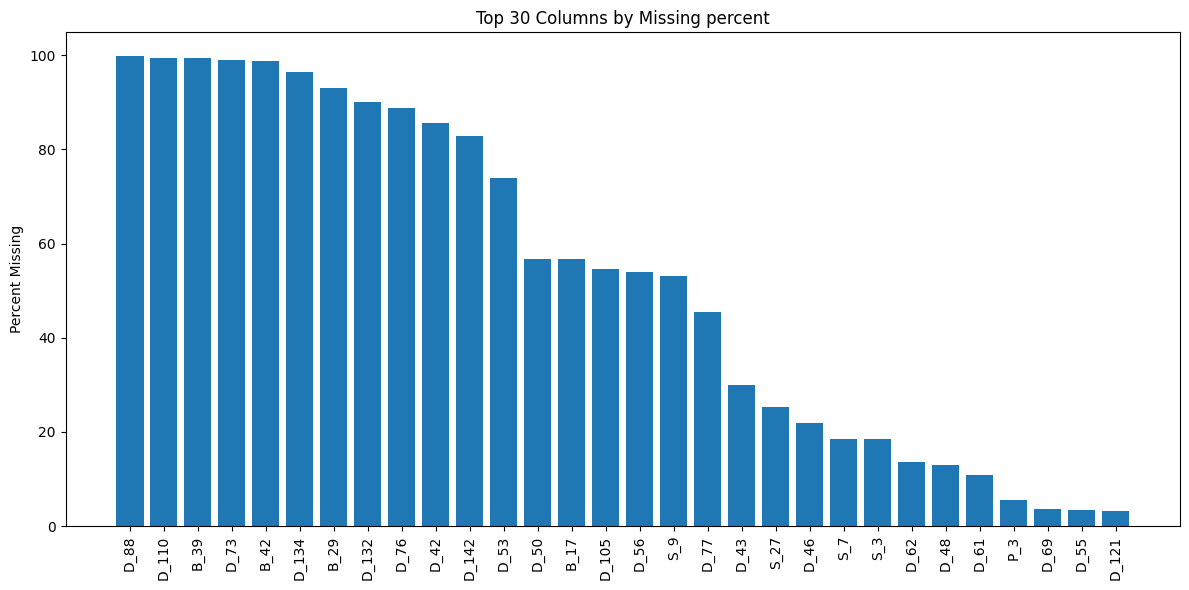

In [22]:
top30 = missing_data.head(30)
plt.figure(figsize=(12,6))
plt.bar(top30.index, top30.values)
plt.xticks(rotation=90)
plt.ylabel('Percent Missing')
plt.title('Top 30 Columns by Missing percent')
plt.tight_layout()
plt.show()

We can see form above bar chart that many columns have a significant number of missing values.

Features with >70% missing: 12

Features with >20% missing: 21

We will drop features with >80% nulls and impute the rest.

In [23]:
for cf in cat_cols:
    unique_vals = df[cf].unique().tolist()
    null_count = df[cf].isnull().sum()
    print(f"{cf}: {unique_vals} | Nulls: {null_count}")


B_30: [0, 2, 1, -1] | Nulls: 0
B_38: [2, 1, 3, 5, 6, 7, 4, -1] | Nulls: 0
D_63: [0, 3, 4, 1, 2, 5] | Nulls: 0
D_64: [0, 2, -1, 3, 1] | Nulls: 0
D_66: [-1, 1, 0] | Nulls: 0
D_68: [6, 2, 3, -1, 5, 4, 0, 1] | Nulls: 0
D_114: [1, 0, -1] | Nulls: 0
D_116: [0, -1, 1] | Nulls: 0
D_117: [5, 0, 7, 3, 2, -1, 4, 6] | Nulls: 0
D_120: [0, 1, -1] | Nulls: 0
D_126: [2, -1, 1, 0] | Nulls: 0


* This prints the unique values and null count for each column in the cat_cols list.

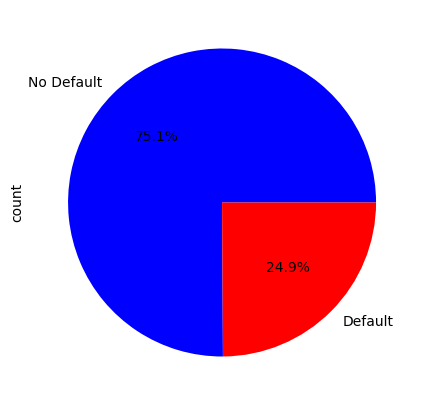

In [24]:
target_cnts = df['target'].value_counts()
target_cnts.plot.pie(autopct='%1.1f%%', labels=['No Default', 'Default'], colors=['blue', 'red'], figsize=(5, 5));

The target dataset is imbalanced, with approximately 25% of customers having defaulted. We will use oversampling to address this imbalance during model training.

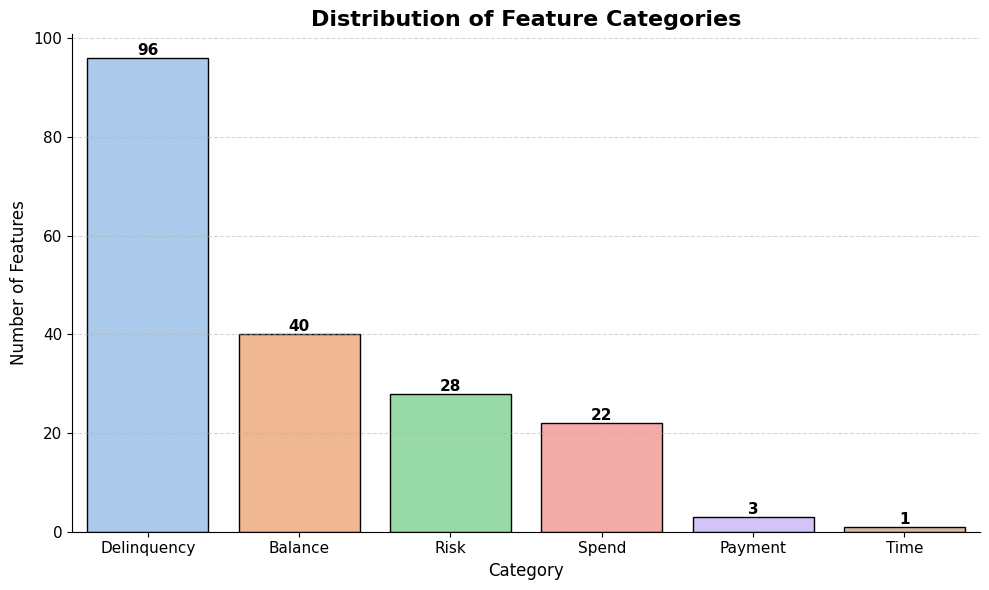

In [25]:
category_map = {
    'D': 'Delinquency',
    'S': 'Spend',
    'P': 'Payment',
    'B': 'Balance',
    'R': 'Risk',
    'T': 'Time'
}

feature_cols = [col for col in sample.columns if col not in ['customer_ID', 'Target']]

category_counts = {}
for col in feature_cols:
    prefix = col[0]
    category = category_map.get(prefix, 'Time')
    category_counts[category] = category_counts.get(category, 0) + 1

dist_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count']).reset_index()
dist_df.columns = ['Category', 'Count']
dist_df = dist_df.sort_values(by='Count', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=dist_df,
    x='Category',
    y='Count',
    palette='pastel',
    edgecolor='black'
)

# Add value labels
for p in barplot.patches:
    barplot.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=11, fontweight='bold'
    )

# Styling
plt.title("Distribution of Feature Categories", fontsize=16, weight='bold')
plt.ylabel("Number of Features", fontsize=12)
plt.xlabel("Category", fontsize=12)
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


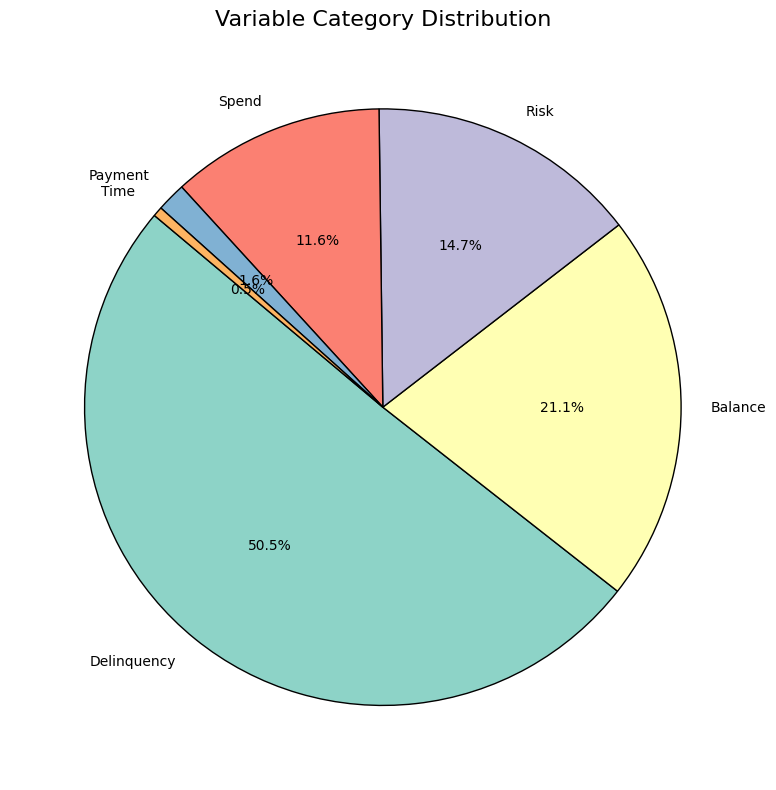

In [26]:
colors = plt.cm.Set3.colors 
fig, ax = plt.subplots(figsize=(8, 8))

ax.pie(
    dist_df['Count'],
    labels=dist_df['Category'],
    autopct='%1.1f%%',     
    startangle=140,          
    colors=colors,
    wedgeprops=dict(edgecolor='black')
)

ax.set_title("Variable Category Distribution", fontsize=16)
plt.tight_layout()
plt.show()


* Delinquency variables dominate (96 features), while payment variables are very sparse (3 features).

* Imbalance suggests focusing on delinquency buckets for predictive power.

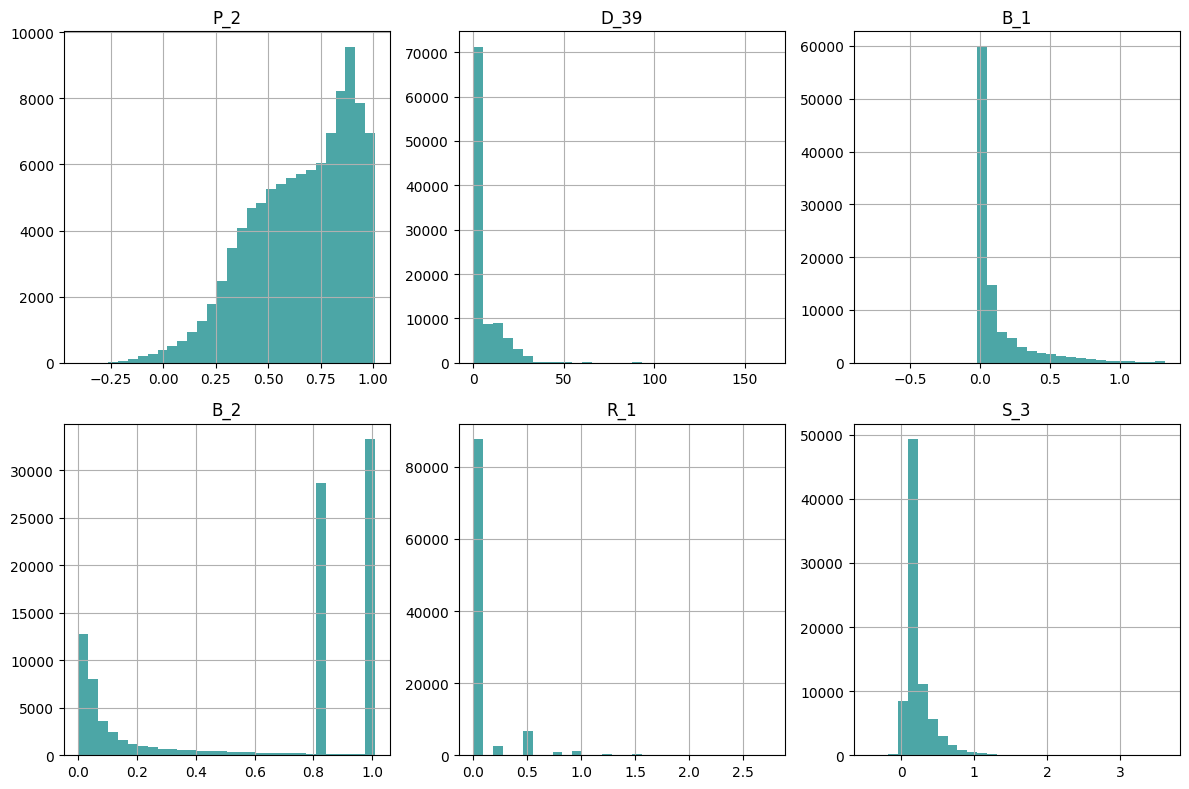

In [27]:
num_cols = sample.select_dtypes(include='number').columns.tolist()

plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols[:6], 1):
    plt.subplot(2,3,i)
    sample[col].hist(bins=30, color='teal', alpha=0.7)
    plt.title(col)
    plt.tight_layout()


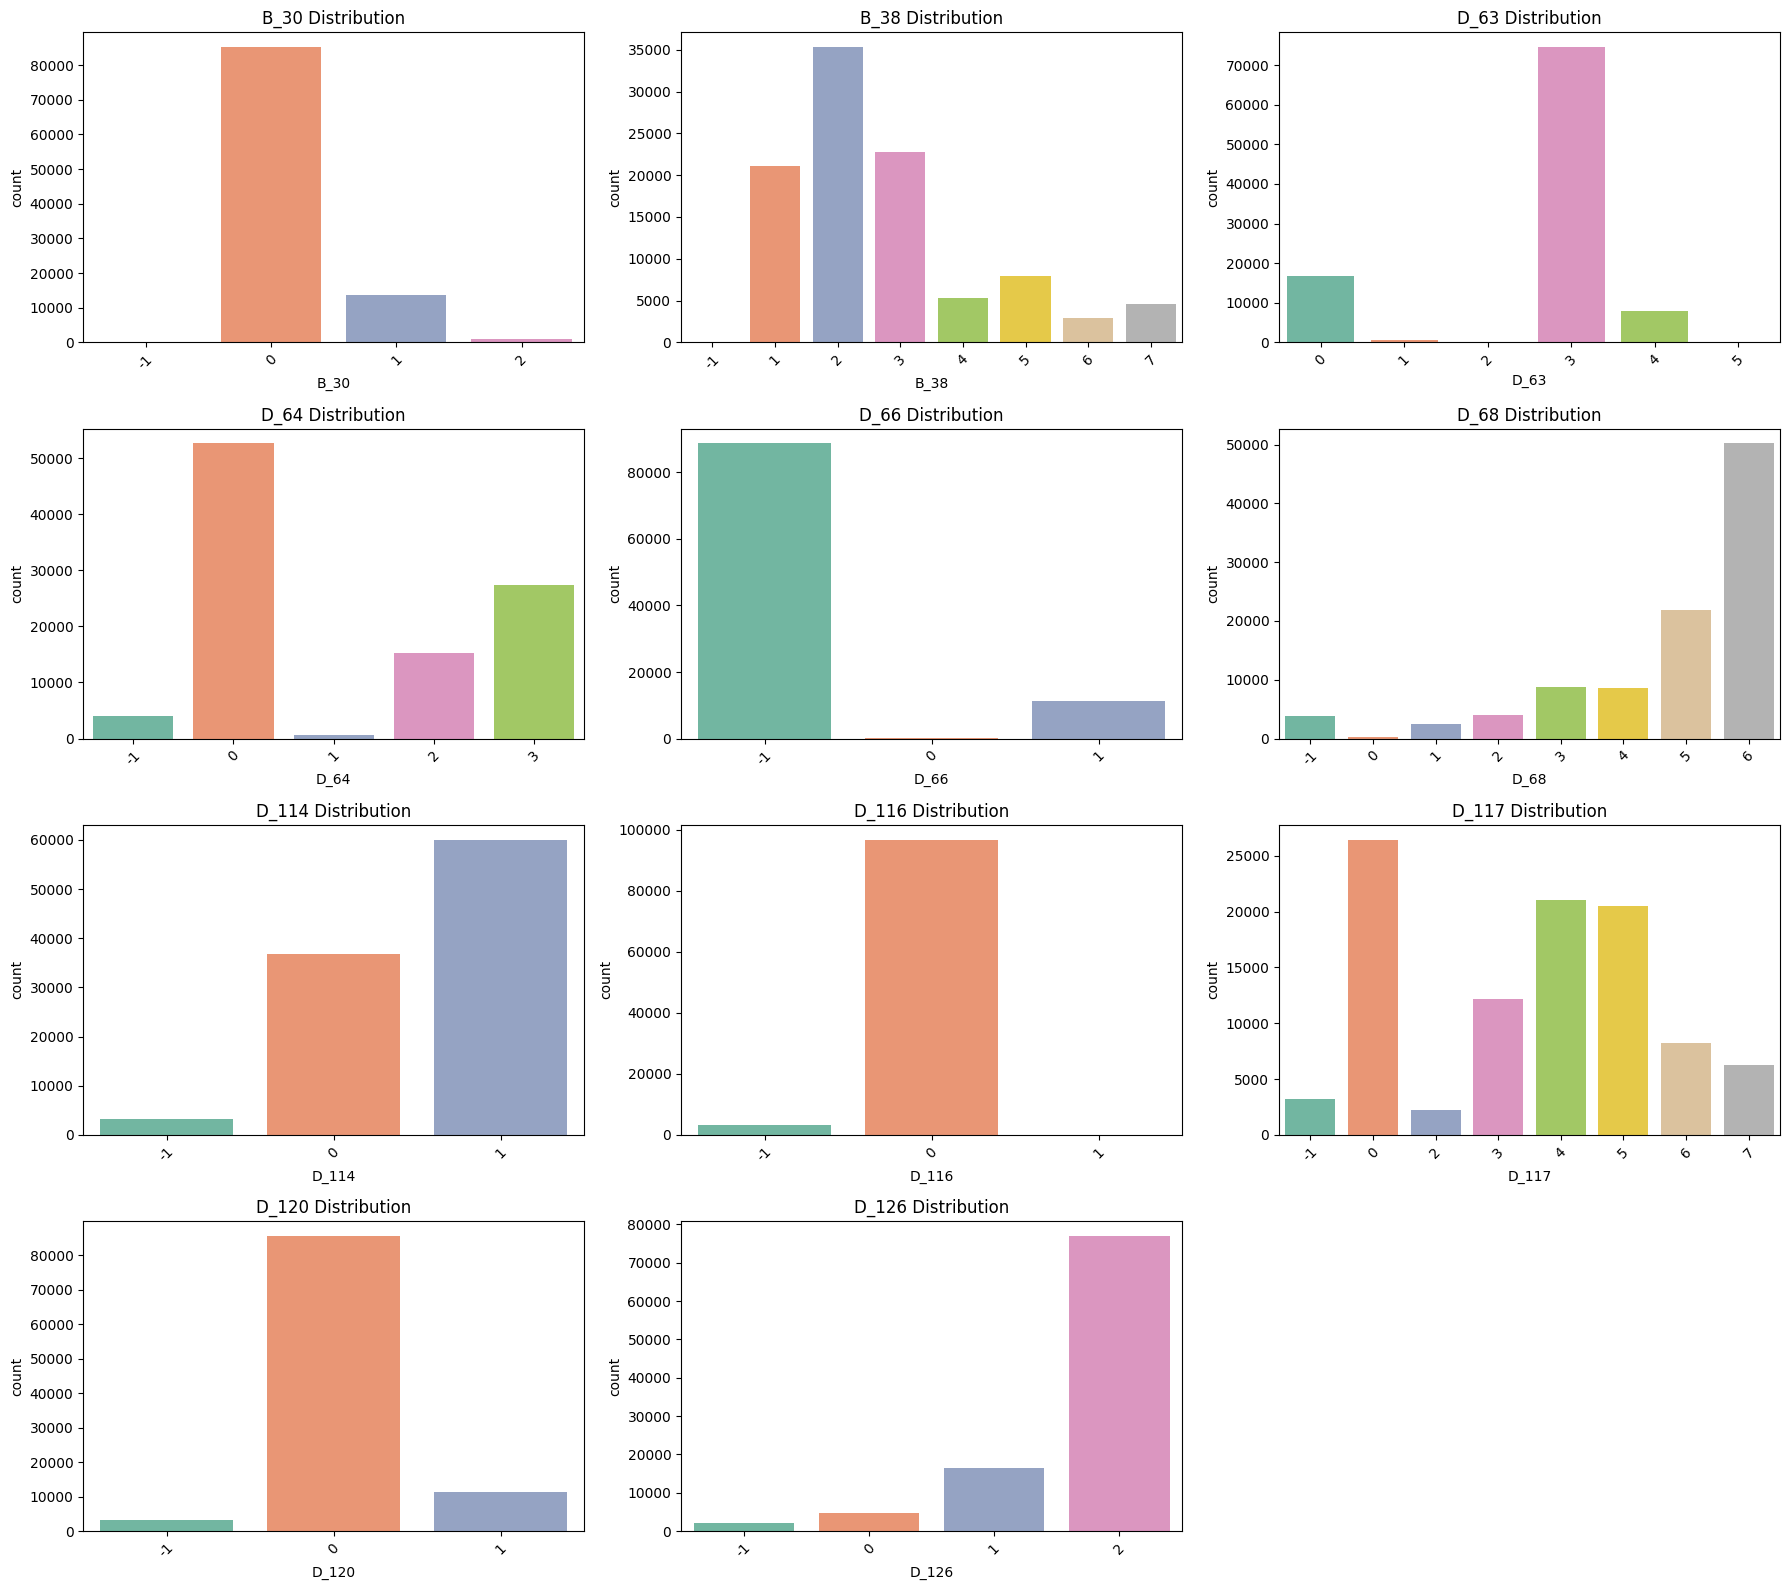

In [28]:
cat_plot_cols = [col for col in cat_cols if col != 'target']
n = len(cat_plot_cols)

ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(cat_plot_cols):
    sns.countplot(data=sample, x=col, ax=axes[i], palette="Set2")
    axes[i].set_title(f"{col} Distribution")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [29]:
record = df.groupby('customer_ID').agg(n_records=('customer_ID', 'count'),
    target=('target', 'last')).reset_index()
record.head()

,customer_ID,n_records,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,13,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,13,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,13,0


In [30]:
record.shape

(458913, 3)

Some Customer had 13 records with target (0,1).

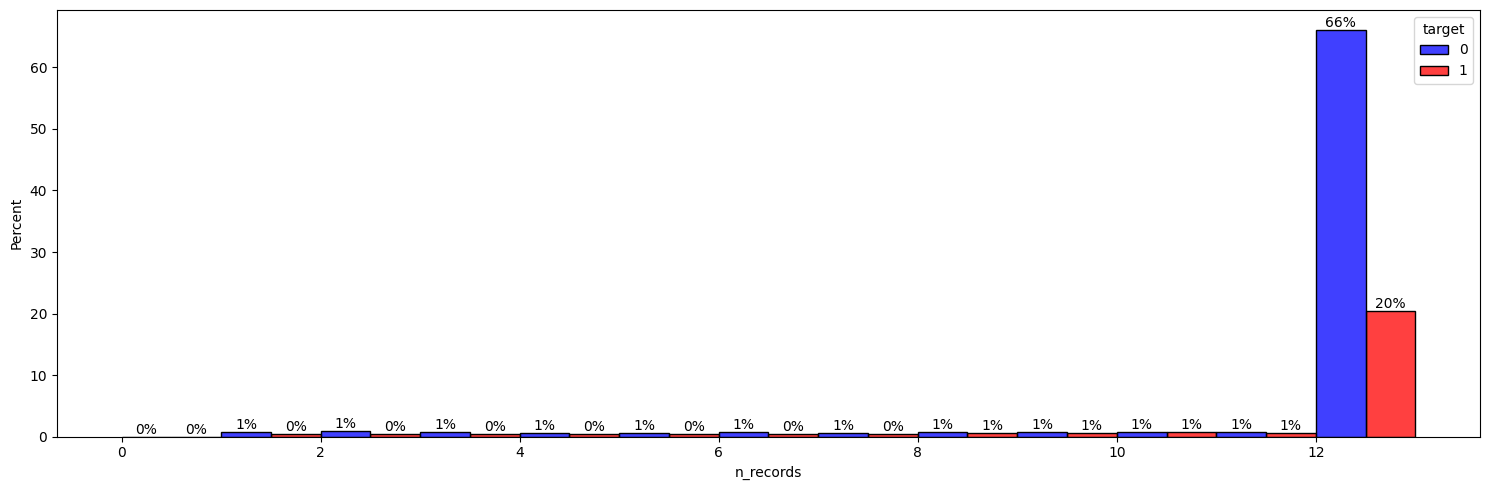

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data=record, x='n_records', hue='target',
    stat='percent', multiple='dodge', bins=np.arange(0, 14),
    palette={0: 'blue', 1: 'red'}, ax=ax
)
ax.bar_label(ax.containers[0], fmt='%.0f%%')
ax.bar_label(ax.containers[1], fmt='%.0f%%')
plt.tight_layout()
plt.show()

In [32]:
sample.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_17,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
count,99161.000000,100000.00000,100000.000000,99956.000000,1.000000e+05,81468.000000,99956.000000,9.995600e+04,14290.000000,69760.000000,100000.000000,100000.000000,99955.000000,1.000000e+05,100000.000000,78258.000000,100000.000000,87112.000000,100000.000000,99995.000000,100000.000000,99622.000000,43224.000000,100000.000000,1.000000e+05,100000.00000,99461.000000,94600.000000,100000.000000,25924.000000,1.000000e+05,1.000000e+05,100000.000000,99956.000000,100000.000000,81468.000000,100000.000000,100000.00000,9.664000e+04,45953.000000,99091.000000,100000.000000,1.000000e+05,46961.000000,100000.000000,100000.000000,1.000000e+05,89245.000000,99880.000000,100000.000000,86300.000000,100000.000000,100000.000000,42978.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,1.000000e+05,9.649400e+04,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1003.000000,100000.000000,100000.000000,100000.000000,11280.000000,1.000000e+05,100000.000000,54797.000000,99880.000000,9.995600e+04,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,9.995600e+04,100000.000000,100000.000000,1.000000e+05,99998.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,6.992000e+03,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,108.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,99673.000000,99991.000000,99681.000000,99766.000000,9.998600e+04,9.927100e+04,100000.000000,98150.000000,45274.000000,100000.000000,100000.000000,1.000000e+05,99998.000000,100000.000000,97613.000000,100000.000000,100000.000000,596.000000,100000.000000,643.000000,99942.000000,99998.000000,7.461500e+04,100000.000000,96817.000000,96817.000000,96817.000000,96817.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,98150.000000,100000.000000,100000.000000,1325.000000,98150.000000,98150.000000,9442.000000,9.922800e+04,100000.000000,3482.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,98150.000000,17053.000000,100000.000000,9.927200e+04,100000.000000,100000.000000
mean,0.657573,5.02768,0.123167,0.623030,7.721099e-02,0.225108,0.054869,1.315567e-01,0.186078,0.153793,0.807940,13.030440,0.252911,8.411697e-02,0.042090,0.475266,0.407568,0.380108,0.340340,0.156988,0.185124,0.447035,0.177975,0.418680,1.890365e-01,1.14870,0.180506,0.601968,0.238317,0.075262,8.796588e-02,1.101277e-01,0.240070,0.980181,0.025820,0.222697,0.094331,1019.89325,2.971164e-01,0.204392,0.102365,0.056950,2.135032e-01,0.074137,0.101450,21.691140,3.758781e-01,0.427781,0.053700,14.275230,0.192145,1.380850,4.102760,0.715587,0.596574,14.420960,3.898450,0.242047,5.645714e-02,258.671840,5.139416e-02,1.643093e-01,0.203420,0.392630,0.070848,0.092660,6.699110,1.705873e-01,0.167087,0.139528,

In [33]:
# 1 One‑hot encode cats
for col in cat_cols:
    df[col] = df[col].astype(object).fillna('Missing')

df_ohe = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype='uint8')

print("Before:", df.shape)
print("After one‑hot encode:", df_ohe.shape)

Before: (5531451, 191)
After one‑hot encode: (5531451, 224)


* 33 new dummy columns added.
* A 100,000-row sample was taken for further analysis.

### Top 10 Features by Correlation with Target

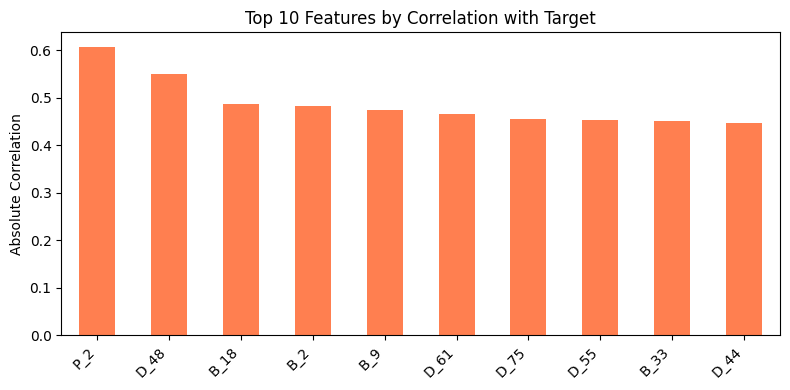

In [34]:
ssample = df_ohe.sample(n=100_000, random_state=42)
ssample = ssample.select_dtypes(exclude=['datetime', 'object'])
numeric_df = ssample.select_dtypes(include='number')

corr_target = (
    numeric_df.corr()['target']
    .abs()
    .sort_values(ascending=False)
    .drop('target')
)

corr_target.head(10).plot(
    kind='bar',
    figsize=(8, 4),
    color='coral'
)
plt.title("Top 10 Features by Correlation with Target")
plt.ylabel("Absolute Correlation")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Visualising the feature using KDE Plots and Correlation Heatmap**

### Distribution and Heatmap of Delinquency Variables

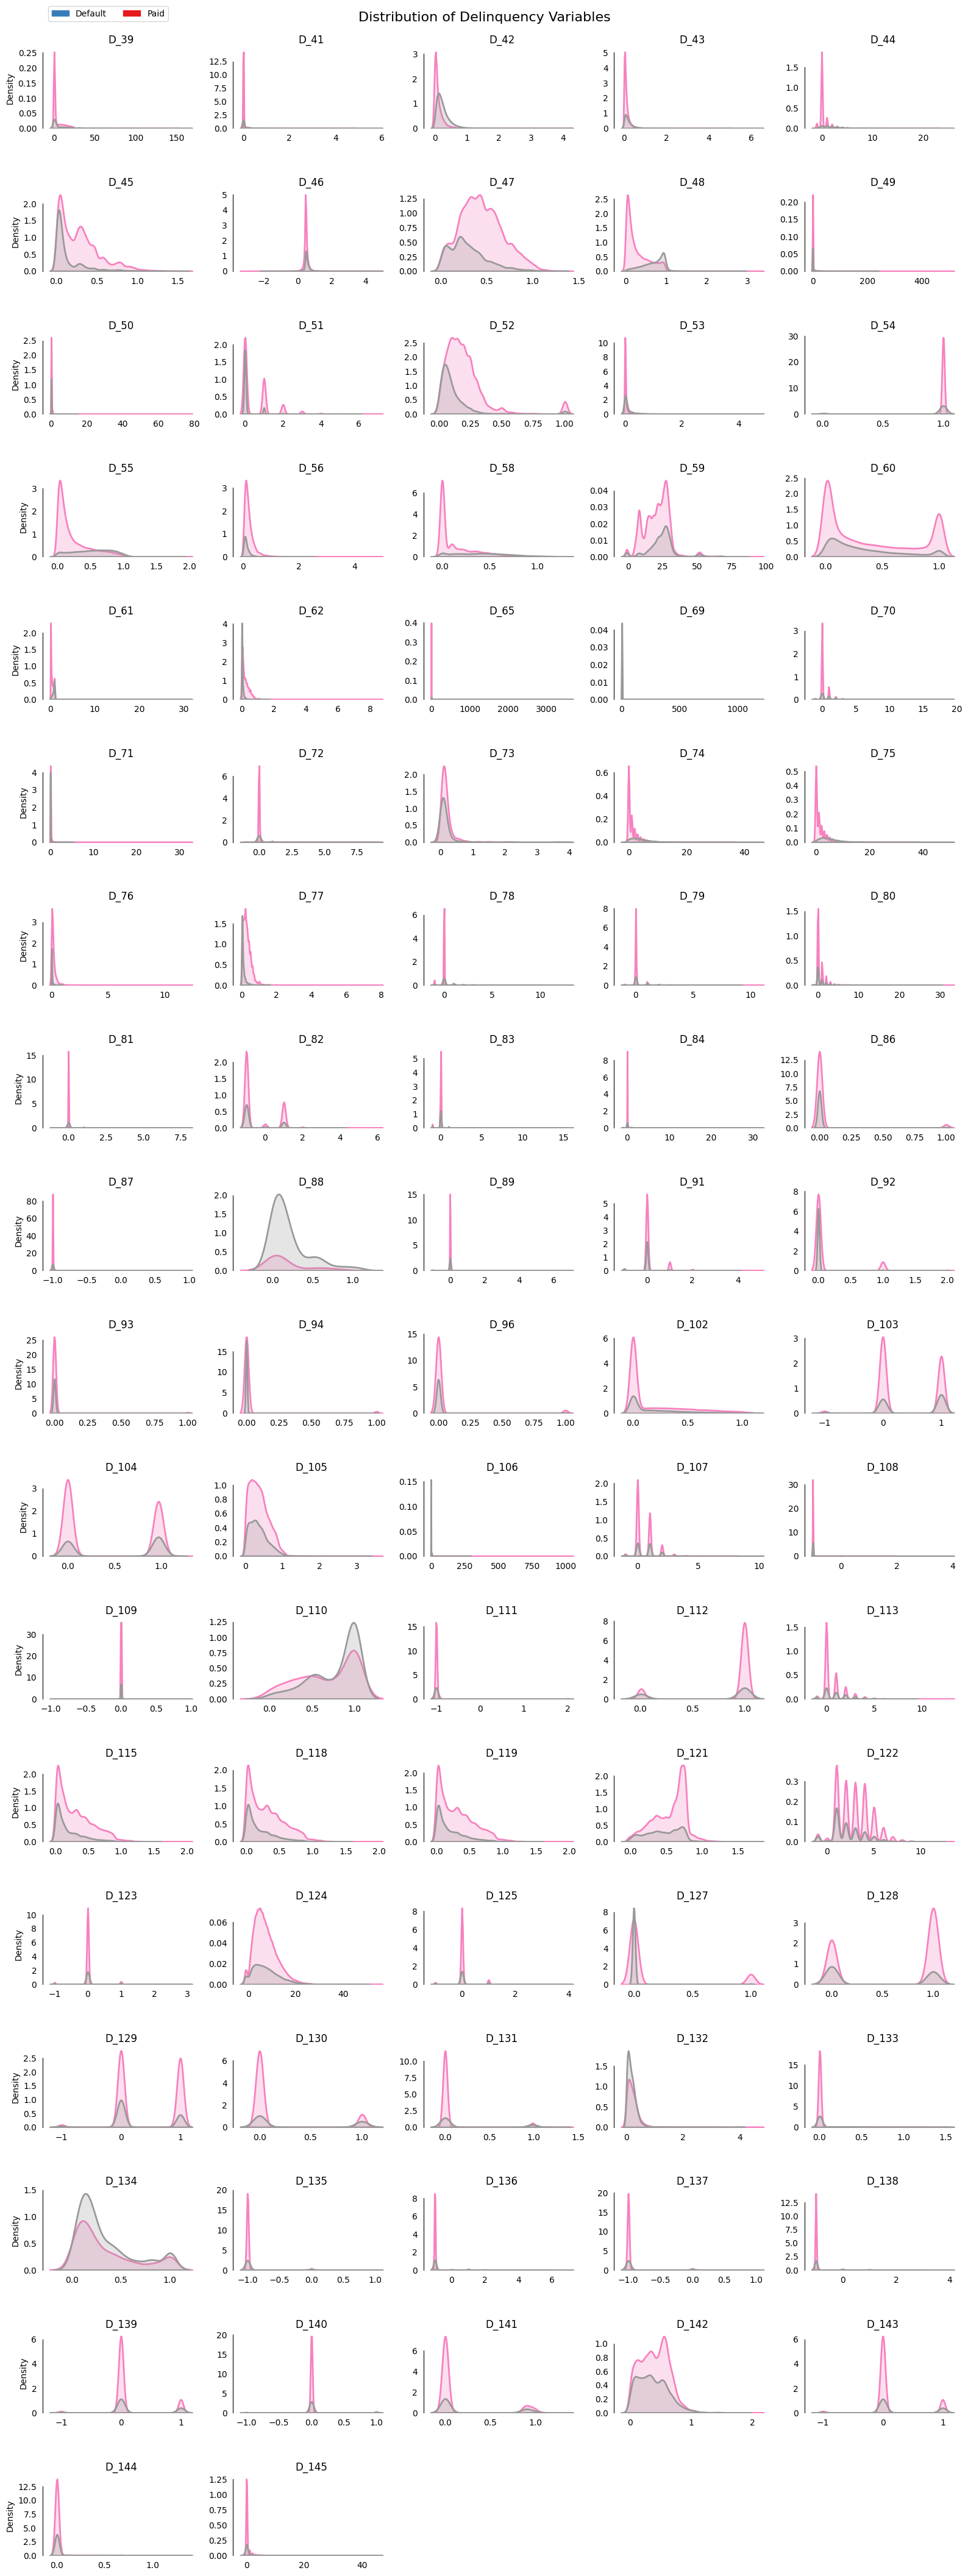

In [35]:
pal = sns.color_palette("Set1")

cols = [
    col for col in sample.columns
    if (col.startswith(("D", "T"))) and (col not in cat_cols)
]

plot_df = sample[cols + ['target']].copy()

n_rows, n_cols = 18, 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 54))
fig.suptitle("Distribution of Delinquency Variables", fontsize=16)

for i, column in enumerate(cols):
    row, col_index = divmod(i, n_cols)
    sns.kdeplot(
        x=column,
        hue="target",
        data=plot_df,
        fill=True,
        linewidth=2,
        palette=pal[::-1],
        hue_order=[1, 0],
        legend=False,
        ax=ax[row, col_index],
    )
    ax[row, col_index].tick_params(left=False, bottom=False)
    ax[row, col_index].set(
        title=f"\n\n{column}",
        xlabel="",
        ylabel=("Density" if col_index == 0 else ""),
    )

for j in range(len(cols), n_rows * n_cols):
    row, col_index = divmod(j, n_cols)
    ax[row, col_index].set_visible(False)

handles = [Patch(color=pal[1], label='Default'), Patch(color=pal[0], label='Paid')]
fig.legend(
    handles=handles,
    labels=["Default", "Paid"],
    ncol=2,
    bbox_to_anchor=(0.18, 0.983)
)

sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
plt.show()


* We observe that although most variables take continuous values between 0 and 1, their density is heavily concentrated around the extremes 0 and 1. This pattern suggests the presence of Gaussian noise around discrete states.

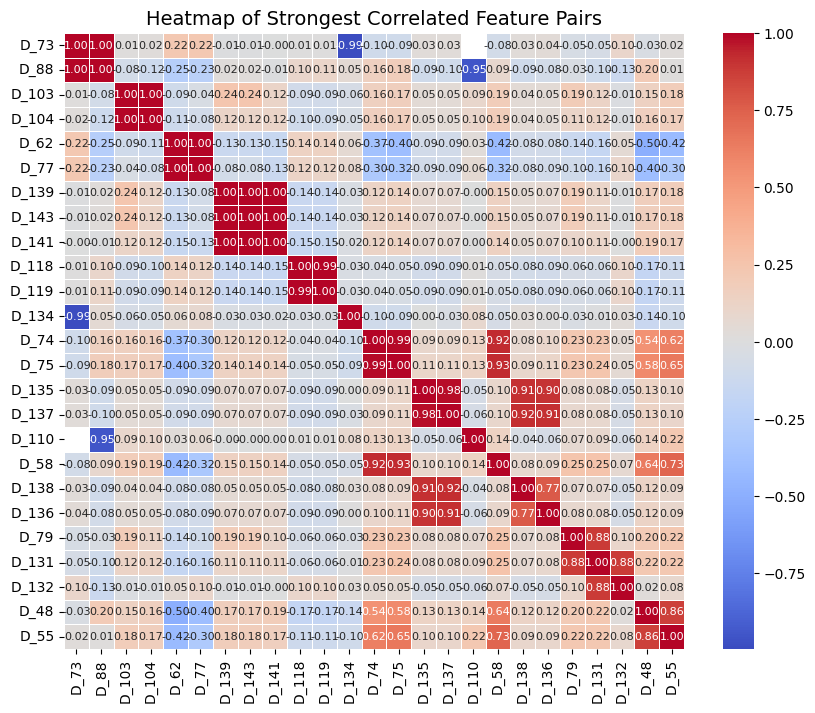

In [36]:
corr_matrix = sample[cols].corr()

high_corr = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)

top_n = 20
top_corr = high_corr.reindex(high_corr['Correlation'].abs().sort_values(ascending=False).index).head(top_n)

top_features = pd.unique(top_corr[['Feature 1', 'Feature 2']].values.ravel())

subset_corr_matrix = sample[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    subset_corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title(f"Heatmap of Strongest Correlated Feature Pairs", fontsize=14)
plt.show()


* We observe that Delinquency 74 and Delinquency 75 are highly correlated, suggesting redundancy; these features can potentially be merged. Similarly, Delinquency 131 and Delinquency 132 exhibit strong correlation and may also be combined.
* Additionally, Delinquency 132 shows weak correlations with other features, likely due to a high proportion of null values in the data

### Distribution and Heatmap of Balance Variables

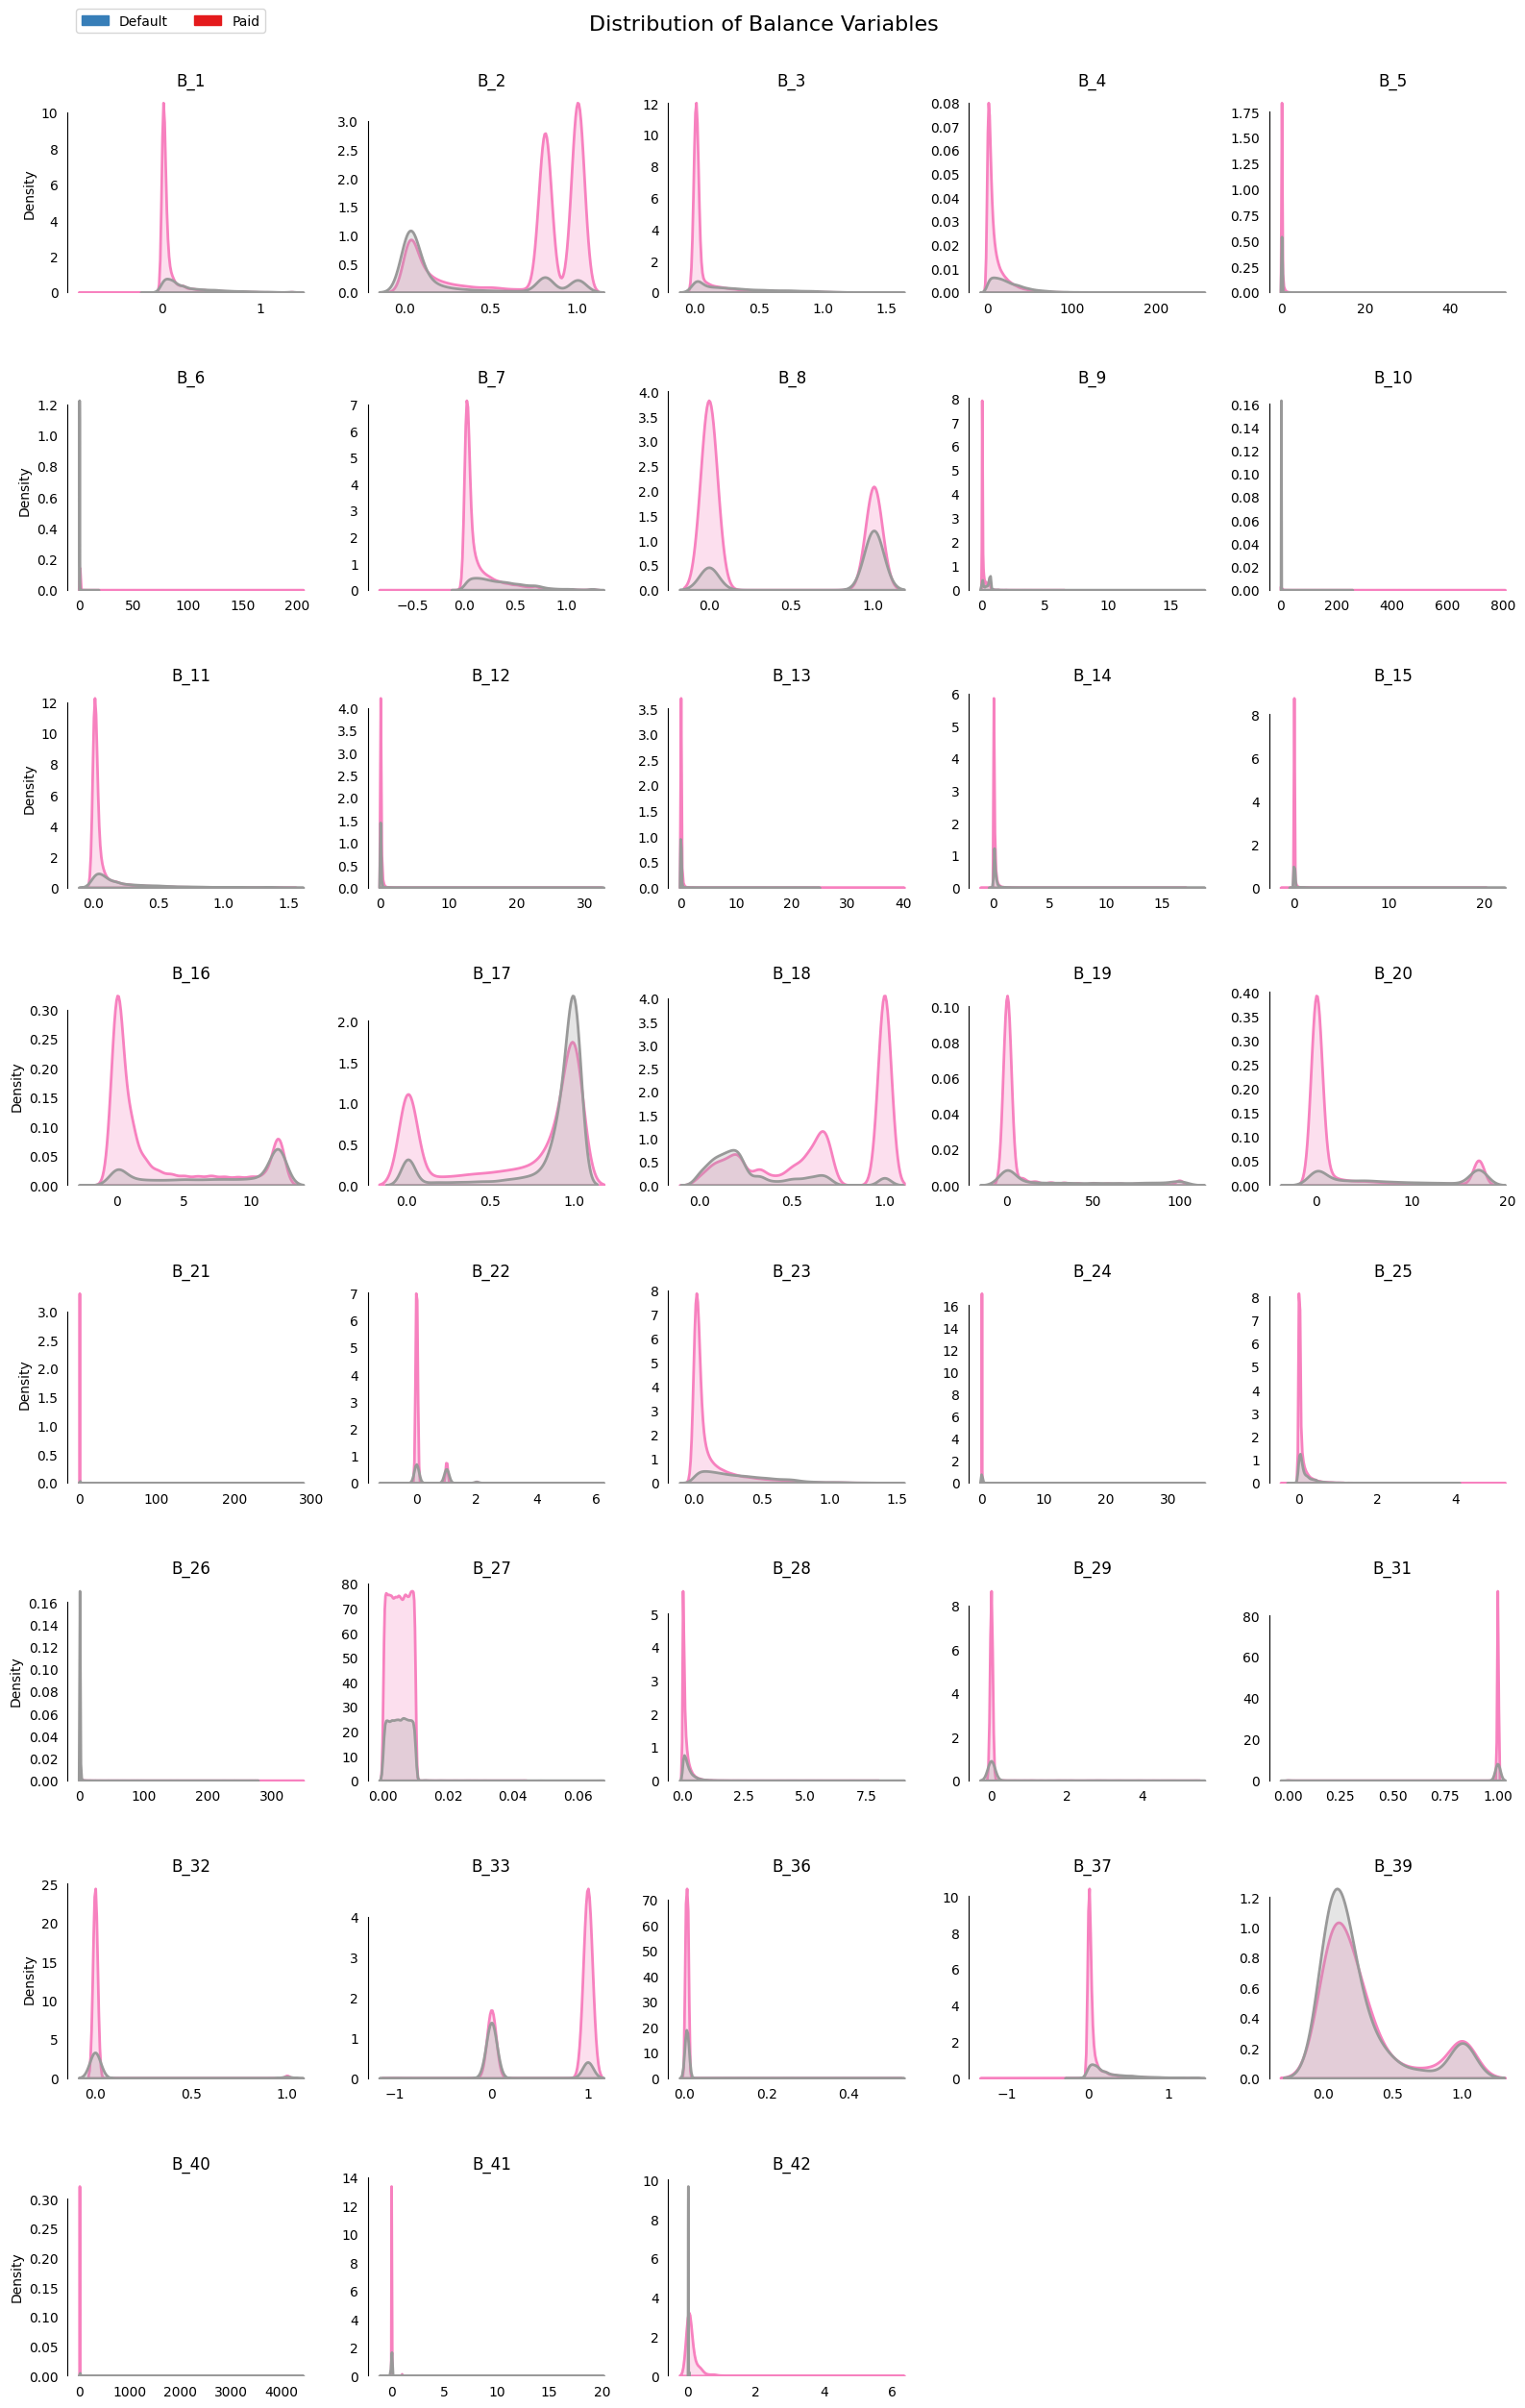

In [37]:
cols = [
    col for col in sample.columns
    if (col.startswith(("B", "T"))) and (col not in cat_cols)
]

plot_df = sample[cols + ['target']].copy()

n_rows, n_cols = 8, 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 32))
fig.suptitle("Distribution of Balance Variables", fontsize=16)

for i, column in enumerate(cols):
    row, col_index = divmod(i, n_cols)
    sns.kdeplot(
        x=column,
        hue="target",
        data=plot_df,
        fill=True,
        linewidth=2,
        palette=pal[::-1],
        hue_order=[1, 0],
        legend=False,
        ax=ax[row, col_index],
    )
    ax[row, col_index].tick_params(left=False, bottom=False)
    ax[row, col_index].set(
        title=f"\n\n{column}",
        xlabel="",
        ylabel=("Density" if col_index == 0 else "")
    )

for j in range(len(cols), n_rows * n_cols):
    row, col_index = divmod(j, n_cols)
    ax[row, col_index].set_visible(False)

handles = [Patch(color=pal[1], label='Default'), Patch(color=pal[0], label='Paid')]
fig.legend(
    handles=handles,
    labels=["Default", "Paid"],
    ncol=2,
    bbox_to_anchor=(0.18, 0.984)
)

sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
plt.show()

* Similar to Delinquency Variables, we observe that even though most varibles have continuous values between 0 and 1, most of the density is just located at either 0 or 1.
* Some features (e.g., B_4, B_5, B_11–B_15) show nearly identical distributions for both target classes, suggesting limited individual predictive power.
* Given the skewed nature and scale differences among the B_ features, preprocessing steps like normalisation is needed to enhance model stability and performance.

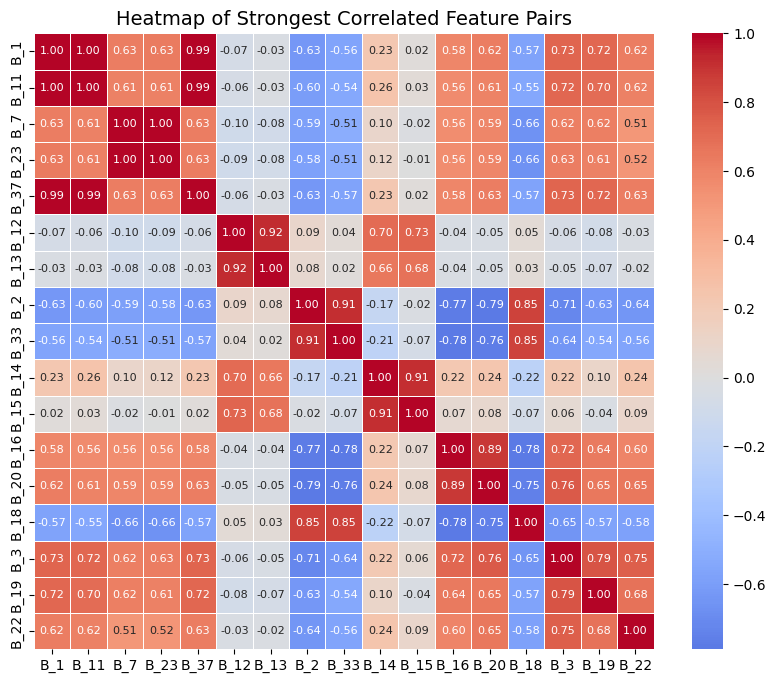

In [38]:
cols = [
    col for col in sample.columns
    if (col.startswith(("B", "T"))) and (col not in cat_cols)
]
corr_matrix = sample[cols].corr()

high_corr = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)

top_n = 20
top_corr = high_corr.reindex(high_corr['Correlation'].abs().sort_values(ascending=False).index).head(top_n)

top_features = pd.unique(top_corr[['Feature 1', 'Feature 2']].values.ravel())

subset_corr_matrix = sample[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    subset_corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title(f"Heatmap of Strongest Correlated Feature Pairs", fontsize=14)
plt.show()


### Distribution and Heatmap of Risk Variables

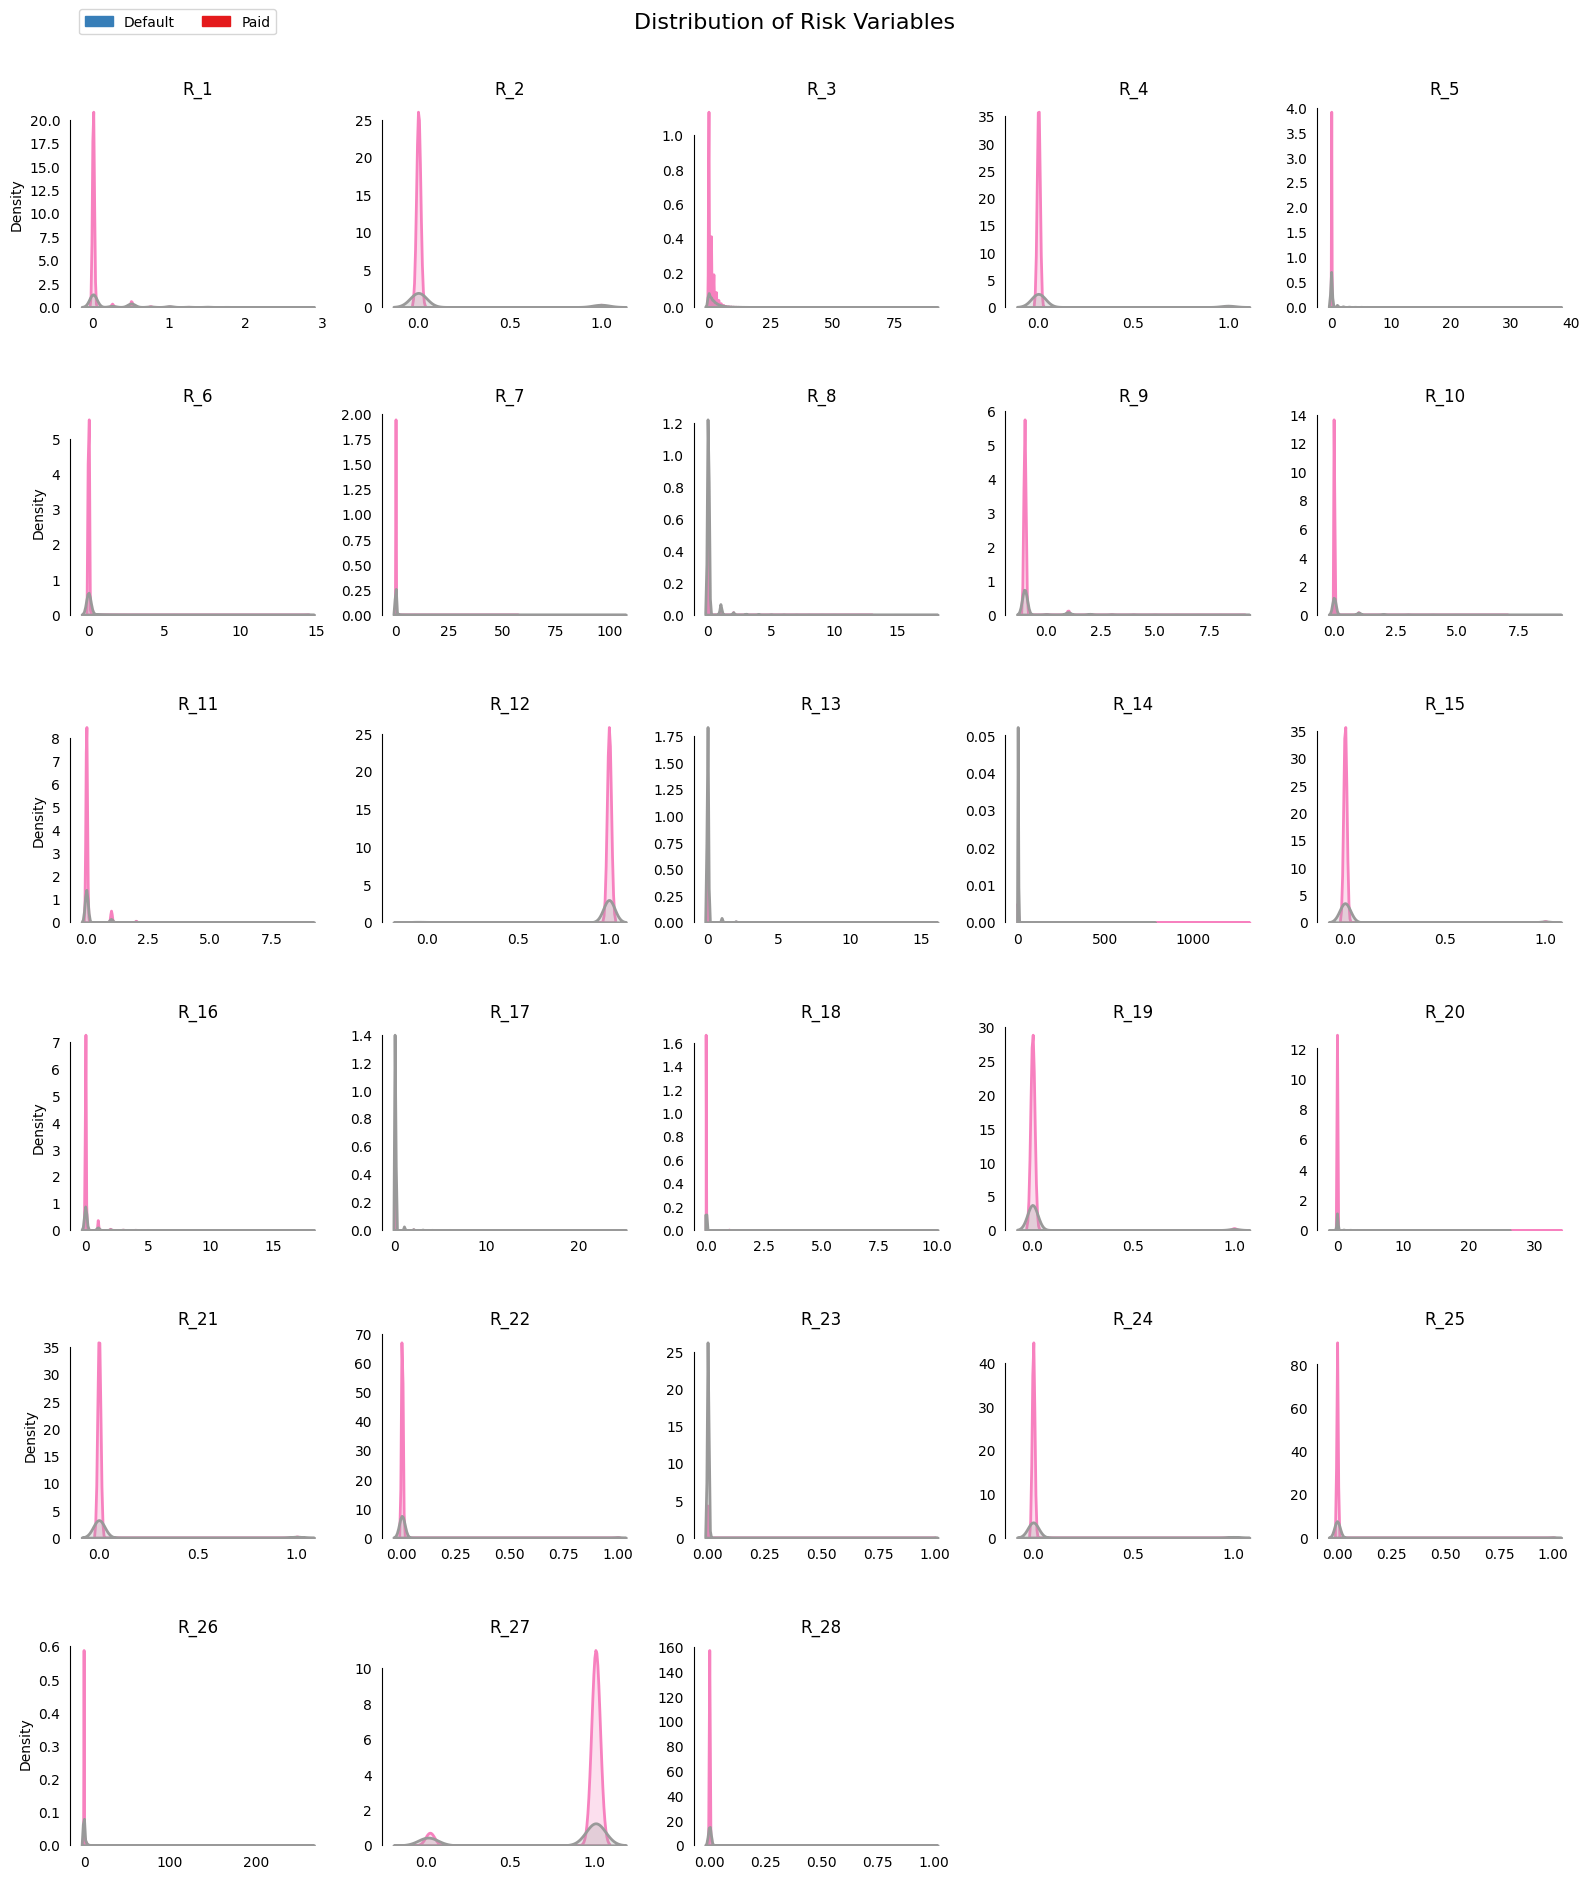

In [39]:
cols = [
    col for col in sample.columns
    if (col.startswith(("R", "T"))) and (col not in cat_cols)
]

plot_df = sample[cols + ['target']].copy()

n_rows, n_cols = 6, 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 24))
fig.suptitle("Distribution of Risk Variables", fontsize=16)

for i, column in enumerate(cols):
    row, col_index = divmod(i, n_cols)
    sns.kdeplot(
        x=column,
        hue="target",
        data=plot_df,
        fill=True,
        linewidth=2,
        palette=pal[::-1],
        hue_order=[1, 0],
        legend=False,
        ax=ax[row, col_index],
    )
    ax[row, col_index].tick_params(left=False, bottom=False)
    ax[row, col_index].set(
        title=f"\n\n{column}",
        xlabel="",
        ylabel=("Density" if col_index == 0 else "")
    )

for j in range(len(cols), n_rows * n_cols):
    row, col_index = divmod(j, n_cols)
    ax[row, col_index].set_visible(False)

handles = [Patch(color=pal[1], label='Default'), Patch(color=pal[0], label='Paid')]
fig.legend(
    handles=handles,
    labels=["Default", "Paid"],
    ncol=2,
    bbox_to_anchor=(0.18, 0.984)
)

sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
plt.show()

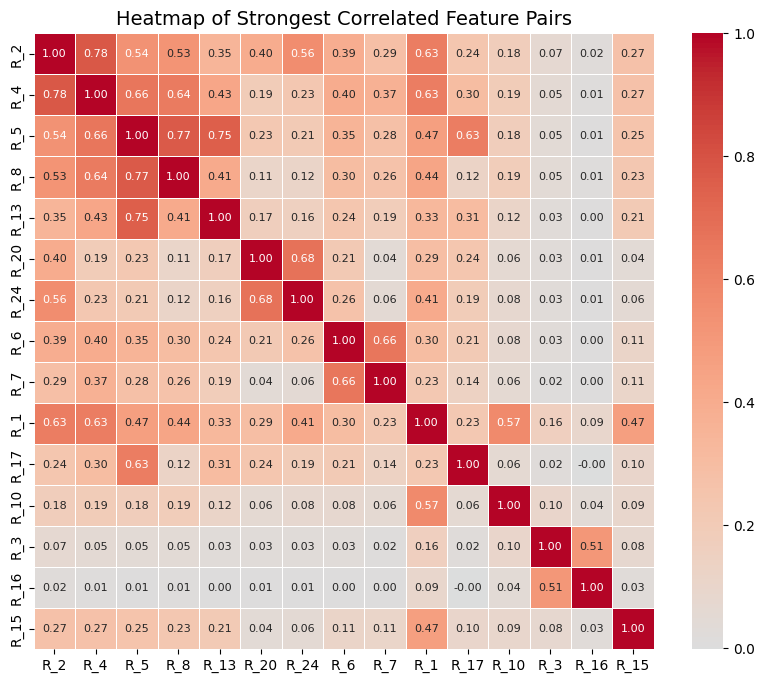

In [40]:
cols = [
    col for col in sample.columns
    if (col.startswith(("R", "T"))) and (col not in cat_cols)
]
corr_matrix = sample[cols].corr()

high_corr = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)

top_n = 20
top_corr = high_corr.reindex(high_corr['Correlation'].abs().sort_values(ascending=False).index).head(top_n)

top_features = pd.unique(top_corr[['Feature 1', 'Feature 2']].values.ravel())

subset_corr_matrix = sample[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    subset_corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title(f"Heatmap of Strongest Correlated Feature Pairs", fontsize=14)
plt.show()


### Distribution and Heatmap of Spend Variables

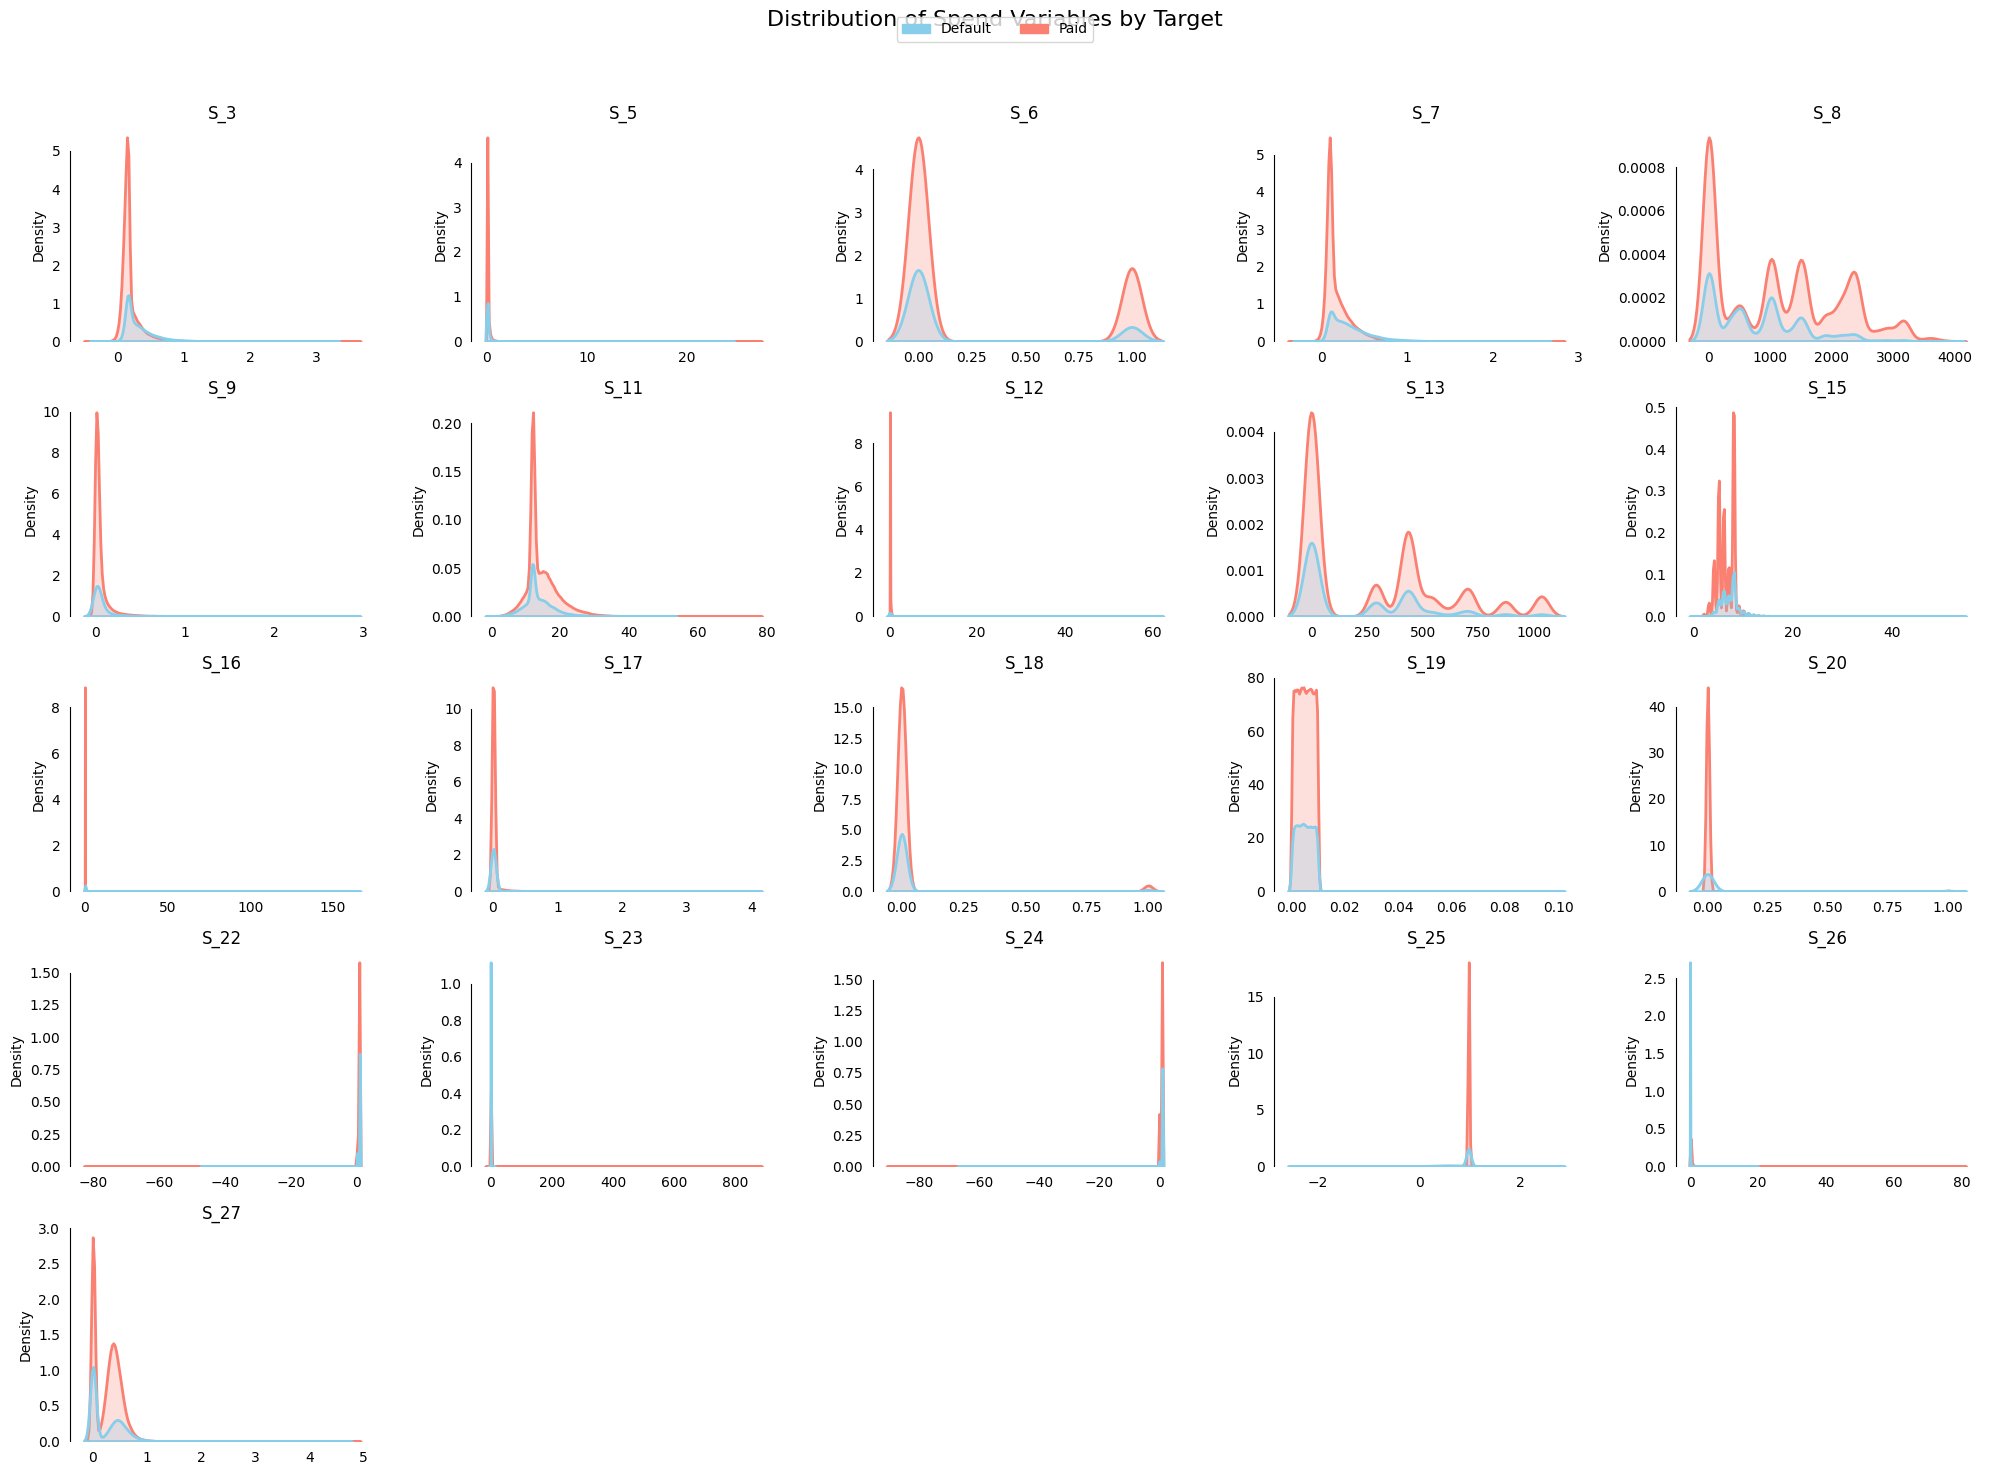

In [41]:
pal = sns.color_palette(["salmon", "skyblue"])

spend_cols = [
    col for col in sample.columns
    if (col.startswith(("S", "T")))
    and (col not in cat_cols)
    and (
        pd.api.types.is_numeric_dtype(sample[col]) or
        pd.api.types.is_datetime64_any_dtype(sample[col])
    )
]

plot_df = sample[spend_cols + ['target']].copy()

n_plots = len(spend_cols)
ncols = 5
nrows = (n_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
fig.suptitle("Distribution of Spend Variables by Target", fontsize=16)

axes = axes.flatten()

for i, col in enumerate(spend_cols):
    ax = axes.flat[i]
    sns.kdeplot(
        x=col,
        hue="target",
        data=plot_df,
        palette=pal[::-1],
        hue_order=[1, 0],
        fill=True,
        linewidth=2,
        legend=False,
        ax=ax
    )
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("Density")
    ax.tick_params(left=False, bottom=False)

for j in range(n_plots, nrows * ncols):
    fig.delaxes(axes.flat[j])

handles = [
    Patch(color=pal[::-1][0], label='Default'),
    Patch(color=pal[::-1][1], label='Paid')
]
fig.legend(handles=handles, ncol=2, bbox_to_anchor=(0.5, 0.98), loc='upper center')

sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


* Most variables are right-skewed with values concentrated near 0.
* Paid customers (red) show sharper and higher peaks, especially in low ranges.
* Several features show clear separation, useful for classification.
* S_12, S_15, S_19, S_24, S_25, S_27 -> Strongly differentiate the two groups, valuable for modeling.
* S_5, S_11, S_16, S_22, S_23, S_26 → Have large values or long tails; may need scaling or transformation.


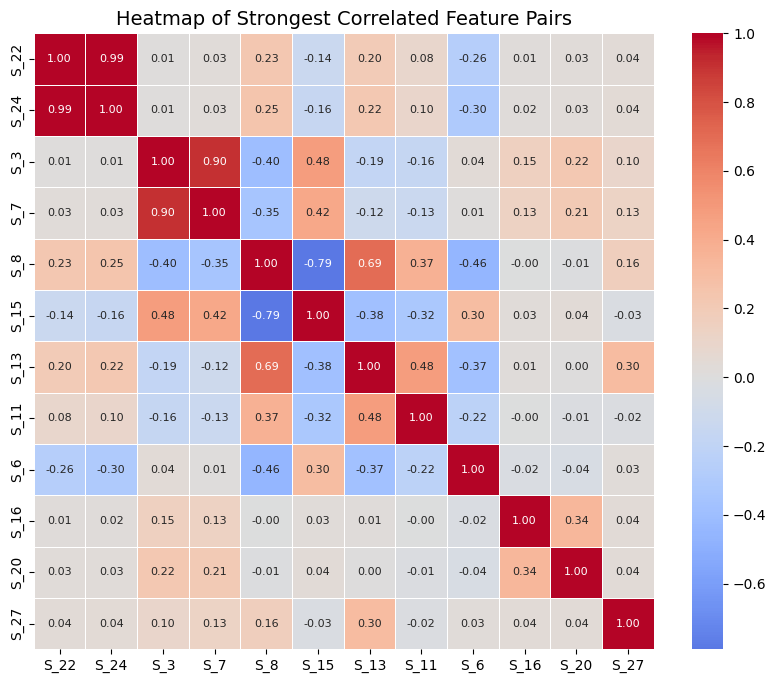

In [42]:
cols = [
    col for col in sample.columns
    if (col.startswith(("S", "T")))
    and (col not in cat_cols)
    and (
        pd.api.types.is_numeric_dtype(sample[col]) or
        pd.api.types.is_datetime64_any_dtype(sample[col])
    )
]
corr_matrix = sample[cols].corr()

high_corr = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)

top_n = 20
top_corr = high_corr.reindex(high_corr['Correlation'].abs().sort_values(ascending=False).index).head(top_n)

top_features = pd.unique(top_corr[['Feature 1', 'Feature 2']].values.ravel())

subset_corr_matrix = sample[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    subset_corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title(f"Heatmap of Strongest Correlated Feature Pairs", fontsize=14)
plt.show()


* We observe that Spend 3 and Spend 7 are highly positively correlated, indicating similar behavior. Spend 8 shows strong negative correlations with both Spend 13 and Spend 15, suggesting inverse relationships.
* Additionally, Spend 22 and Spend 24 are also highly positively correlated.

### Distribution and Heatmap of Payment Variables

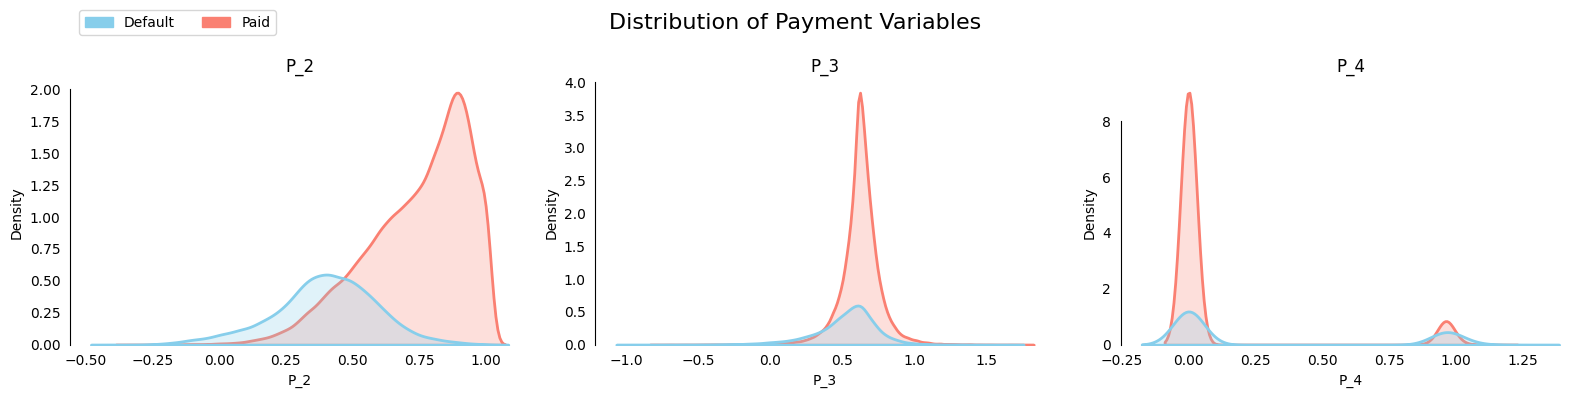

In [43]:
pal = sns.color_palette(["salmon", "skyblue"])

cols = [c for c in sample.columns if c.startswith(('P', 'T'))][:4]

fig, ax = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Distribution of Payment Variables", fontsize=16)

for i, col in enumerate(cols):
    sns.kdeplot(
        x=col,
        hue="target",
        data=sample,
        palette=pal[::-1],
        hue_order=[1, 0],
        fill=True,
        linewidth=2,
        legend=False,
        ax=ax[i]
    )
    ax[i].set(title=col)
    ax[i].tick_params(left=False, bottom=False)

handles = [
    Patch(color=pal[::-1][0], label='Default'),
    Patch(color=pal[::-1][1], label='Paid')
]
fig.legend(handles=handles, ncol=2, bbox_to_anchor=(0.18, 1))

sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
plt.show()


* We notice that Payment 2 is heavily negatively skewed (left skewed). The other variables seem to have densities clustered around 0 and 1.

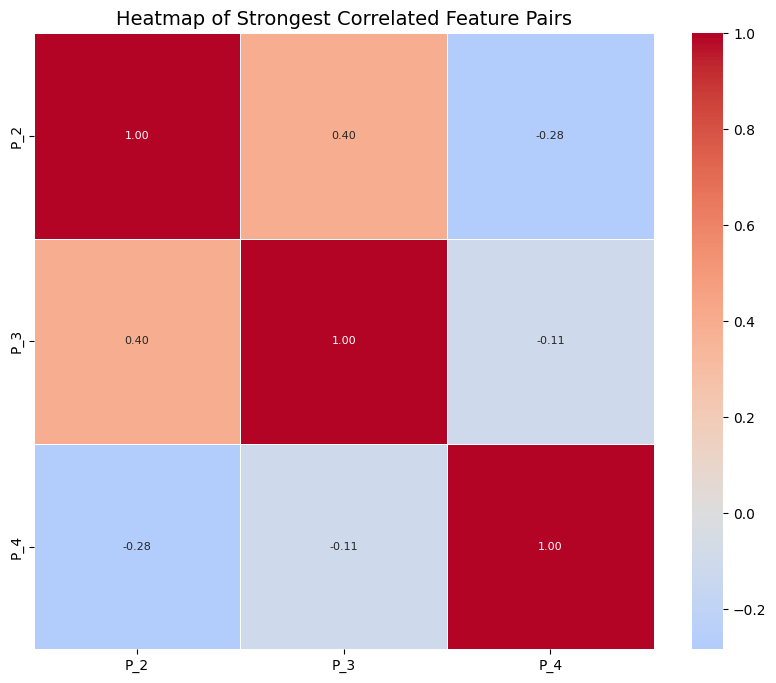

In [44]:
pt_cols = [c for c in sample.columns if c.startswith(('P','T'))]

corr_matrix = sample[pt_cols].corr()

high_corr = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)

top_n = 20
top_corr = high_corr.reindex(high_corr['Correlation'].abs().sort_values(ascending=False).index).head(top_n)

top_features = pd.unique(top_corr[['Feature 1', 'Feature 2']].values.ravel())

subset_corr_matrix = sample[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    subset_corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title(f"Heatmap of Strongest Correlated Feature Pairs", fontsize=14)
plt.show()


* We observe a strong negative correlation between Payment 2 and the target variable. This likely reflects the intuitive relationship that individuals who consistently make payments are less likely to default.
* P_2 and P_3 are positively correlated, meaning customers with high P_2 tend to have high P_3 as well.
* P_4 is weakly correlated with both P_2 and P_3

### **Outlier Detection and Handling**

In [46]:
# Identify numeric columns
numeric_cols = [c for c in sample.select_dtypes('number').columns if c != 'target']

# IQR-based outlier detection
iqr_outliers = {}
for col in numeric_cols:
    Q1 = sample[col].quantile(0.25)
    Q3 = sample[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = (sample[col] < lower_bound) | (sample[col] > upper_bound)
    iqr_outliers[col] = outlier_mask.sum()

# Display top 10 features with most IQR-based outliers
pd.Series(iqr_outliers).sort_values(ascending=False).head(10)

S_12     25191
S_6      24007
S_24     23672
S_22     23659
S_26     22135
B_19     20539
D_139    18905
D_145    18905
D_143    18892
B_22     18819
dtype: int64

In [47]:
from scipy.stats import median_abs_deviation

modz_outliers = {}
for col in numeric_cols:
    median = sample[col].median()
    mad = median_abs_deviation(sample[col], nan_policy='omit')
    if mad == 0:
        modz_outliers[col] = 0
        continue
    z_scores = 0.6745 * (sample[col] - median) / mad
    outlier_mask = z_scores.abs() > 3.5
    modz_outliers[col] = outlier_mask.sum()

# Display top 10 features with most Modified Z-score outliers
pd.Series(modz_outliers).sort_values(ascending=False).head(10)


D_102    42383
D_128    41294
B_3      34628
B_9      33871
B_16     31451
S_12     30939
S_24     24604
B_11     24500
S_22     24399
S_5      24209
dtype: int64

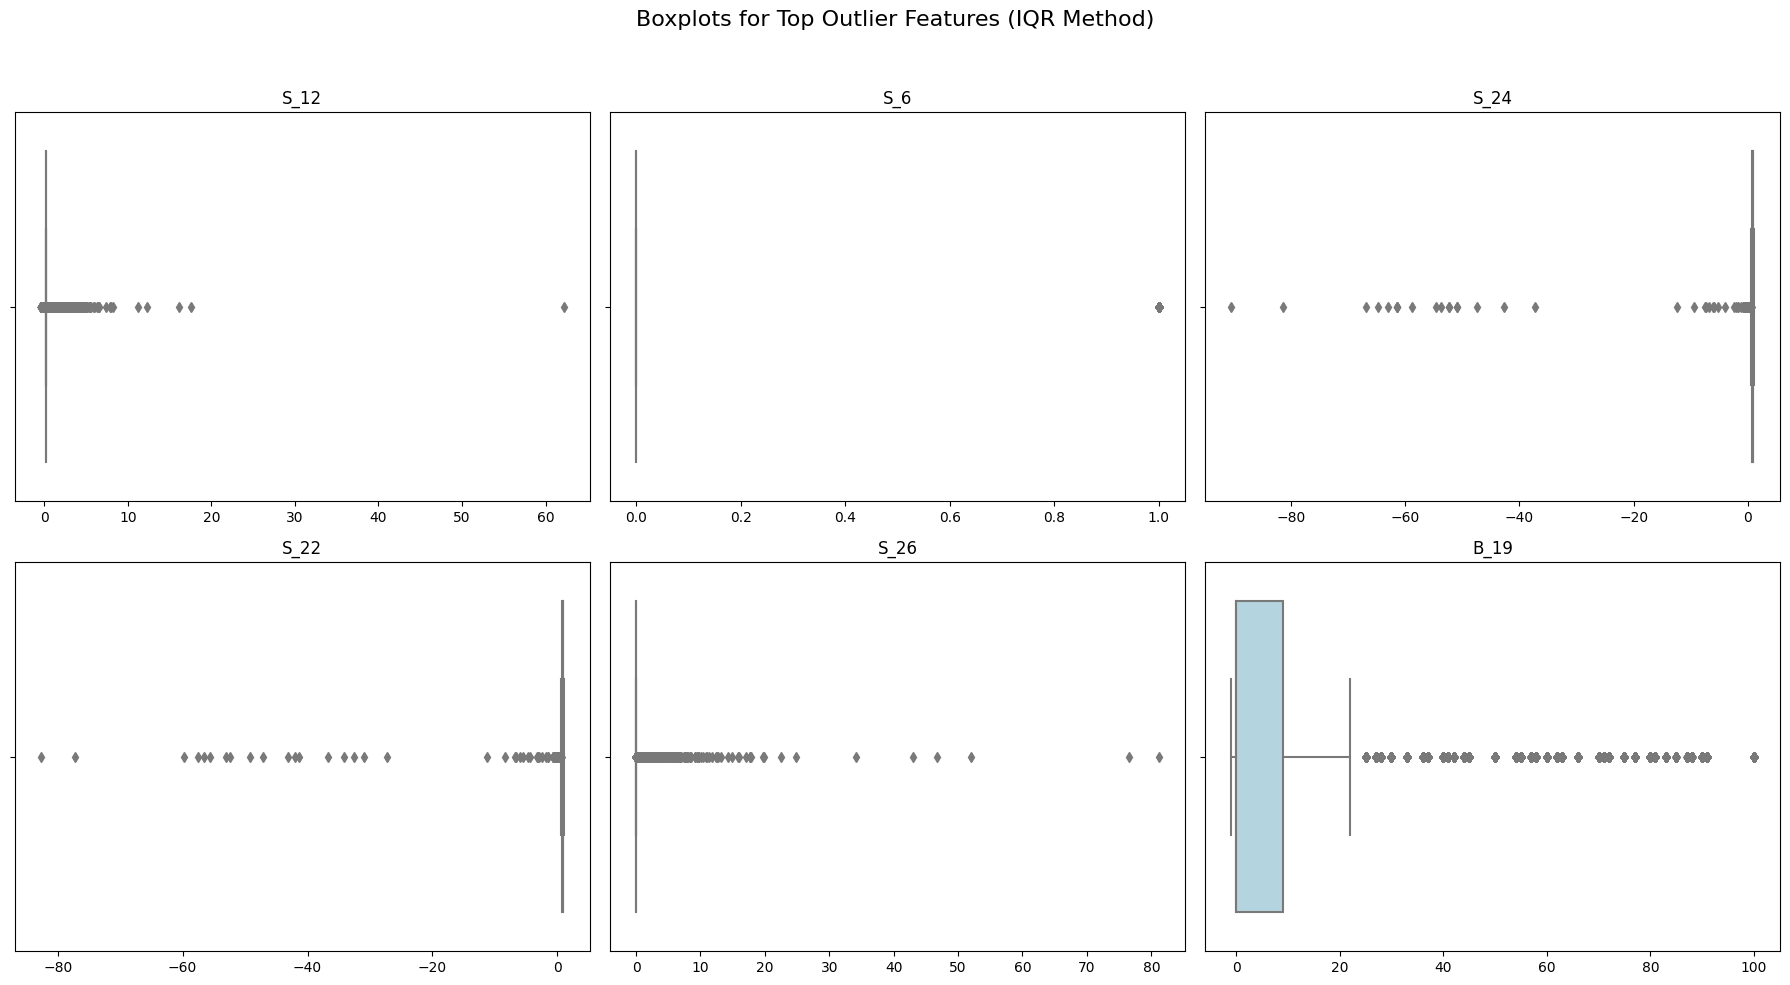

In [48]:
# Top features with highest IQR-based outliers
top_outlier_cols = pd.Series(iqr_outliers).sort_values(ascending=False).head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Boxplots for Top Outlier Features (IQR Method)", fontsize=16)

for i, col in enumerate(top_outlier_cols):
    ax = axes[i//3, i%3]
    sns.boxplot(x=sample[col], ax=ax, color="lightblue")
    ax.set_title(col)
    ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [49]:
sample_cleaned = sample.copy()

for col in numeric_cols:
    lower, upper = sample_cleaned[col].quantile([0.05, 0.95])
    sample_cleaned[col] = sample_cleaned[col].clip(lower, upper)

Q1 = sample_cleaned[numeric_cols].quantile(0.25)
Q3 = sample_cleaned[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = np.ones(len(sample_cleaned), dtype=bool)
for col in numeric_cols:
    mask &= sample_cleaned[col].between(lower_bound[col], upper_bound[col])

sample_cleaned = sample_cleaned.loc[mask].copy()

for col in numeric_cols:
    min_val = sample_cleaned[col].min()
    shift = 1 - min_val if min_val <= 0 else 0
    sample_cleaned[f"log_{col}"] = np.log1p(sample_cleaned[col] + shift)

print("Done")

Done


* Capping numeric features at the 5th and 95th percentiles retains rows and controls extreme values.

* Log‑transforming highly skewed features reduces long‑tail impact and stabilizes variance.



In [52]:
features_to_scale = sample.drop(columns=['customer_ID', 'S_2'] + cat_cols + ['target']).columns

sample_scaled = sample.copy()

scaler = RobustScaler()
sample_scaled[features_to_scale] = scaler.fit_transform(sample_scaled[features_to_scale])

print("Robust-scaled sample shape:", sample_scaled.shape)


Robust-scaled sample shape: (100000, 191)


* This is just Robust feature scaling

### **Handling Missing Values**

In [53]:
missing_threshold = 80

cols_to_drop = missing_data[missing_data > missing_threshold].index.tolist()
df = df.drop(columns=cols_to_drop)
print(f"Dropped columns with >{missing_threshold}% missing values: {cols_to_drop}")

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='category').columns.tolist()

numerical_cols_with_missing = df[numerical_cols].columns[df[numerical_cols].isnull().any()].tolist()
categorical_cols_with_missing = df[categorical_cols].columns[df[categorical_cols].isnull().any()].tolist()

# Impute numerical columns with the mean
for col in numerical_cols_with_missing:
    if col != 'target': 
        mean_val = df[col].mean()
        df[col].fillna(mean_val, inplace=True)
        print(f"Imputed numerical column '{col}' with the mean ({mean_val:.4f})")

# Impute categorical columns with the mode
for col in categorical_cols_with_missing:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)
    print(f"Imputed categorical column '{col}' with the mode ('{mode_val}')")

print("\nMissing values after imputation:")
print(df.isna().sum().sum())

Dropped columns with >80% missing values: ['D_88', 'D_110', 'B_39', 'D_73', 'B_42', 'D_134', 'B_29', 'D_132', 'D_76', 'D_42', 'D_142']
Imputed numerical column 'P_2' with the mean (0.6563)
Imputed numerical column 'B_2' with the mean (0.6215)
Imputed numerical column 'S_3' with the mean (0.2258)
Imputed numerical column 'D_41' with the mean (0.0554)
Imputed numerical column 'B_3' with the mean (0.1325)
Imputed numerical column 'D_43' with the mean (0.1547)
Imputed numerical column 'D_45' with the mean (0.2522)
Imputed numerical column 'D_46' with the mean (0.4755)
Imputed numerical column 'D_48' with the mean (0.3816)
Imputed numerical column 'B_6' with the mean (0.1521)
Imputed numerical column 'B_8' with the mean (0.4478)
Imputed numerical column 'D_50' with the mean (0.1744)
Imputed numerical column 'D_52' with the mean (0.1801)
Imputed numerical column 'P_3' with the mean (0.6013)
Imputed numerical column 'D_53' with the mean (0.0762)
Imputed numerical column 'D_54' with the mean (

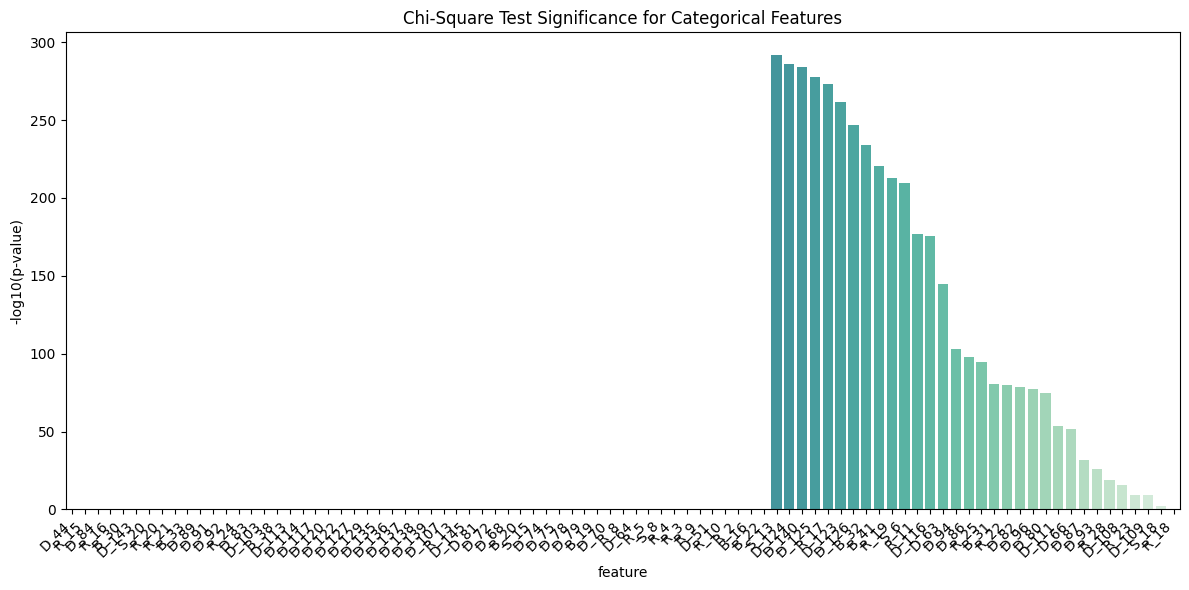

   feature          chi2       p_value
0     D_44  27672.319359  0.000000e+00
1     R_15   1717.083663  0.000000e+00
2     D_84   6232.304677  0.000000e+00
3     R_16   1885.556638  0.000000e+00
4     B_30  13092.884006  0.000000e+00
..     ...           ...           ...
82   D_108     78.550848  3.531345e-16
83    R_23     38.527168  5.399678e-10
84   D_109     41.761295  8.543779e-10
85    S_18      7.610756  5.802114e-03
86    R_18      4.037433  2.574503e-01

[87 rows x 3 columns]


In [54]:
samp_df = df.sample(n=100_000, random_state=42)

cat_cols = [
    c for c in samp_df.columns
    if (samp_df[c].dtype == 'object') or (samp_df[c].nunique() <= 50)
]
cat_cols = [c for c in cat_cols if c != 'target']

# Chi-Square test
chi2_results = []
for col in cat_cols:
    cont_table = pd.crosstab(samp_df[col], samp_df['target'])
    chi2, p, dof, _ = chi2_contingency(cont_table)
    chi2_results.append({'feature': col, 'chi2': chi2, 'p_value': p})

chi2_df = pd.DataFrame(chi2_results).sort_values('p_value').reset_index(drop=True)
chi2_df['neg_log_p'] = -np.log10(chi2_df['p_value'])

plt.figure(figsize=(12, 6))
sns.barplot(data=chi2_df, x='feature', y='neg_log_p', palette='mako')
plt.xticks(rotation=45, ha='right')
plt.ylabel('-log10(p-value)')
plt.title('Chi‑Square Test Significance for Categorical Features')
plt.tight_layout()
plt.show()

print(chi2_df[['feature', 'chi2', 'p_value']])

* D_39, B_30, D_44, D_59, all have p‑values far below 10⁻³⁰, indicating their category levels are highly dependent on whether a customer defaults.

* Delinquency categories (D_39, D_44) show the strongest association with default (p < 10⁻³⁰).

* Certain balance buckets (B_30) also differ significantly between defaulters and non‑defaulters.


### **Feature Engineering**

In [55]:
sample = df.copy()

sample['spend'] = sample[['S_3', 'S_5', 'S_6', 'S_7', 'S_8']].sum(axis=1)
sample['payment_amt'] = sample[['P_2', 'P_3', 'P_4']].sum(axis=1)
sample['delinquency_days'] = sample[['D_39', 'D_41', 'D_45', 'D_43', 'D_44']].sum(axis=1)

# Aggregation-based features
agg_features = sample.groupby('customer_ID').agg({
    'spend': ['mean', 'std', 'max', 'last'],
    'payment_amt': ['sum', lambda x: (x > 0).mean()], 
    'delinquency_days': ['mean', 'count']             
})
agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]
agg_features.reset_index(inplace=True)
print("done")

done


* Aggregated Customer Features:

* Average spend and last payment amount per customer capture overall behavior and recency.

In [56]:
# Trend feature: spending slope over time
def calculate_spend_trend(group):
    x = np.arange(len(group))
    y = group['spend'].values
    if len(x) < 2:
        return 0
    return np.polyfit(x, y, 1)[0]  

spend_trend = sample.groupby('customer_ID').apply(calculate_spend_trend).rename('spend_trend').reset_index()

last_payment = sample.groupby('customer_ID')['payment_amt'].last().rename('last_payment_amt').reset_index()

customer_summary = agg_features.merge(spend_trend, on='customer_ID', how='left')
customer_summary = customer_summary.merge(last_payment, on='customer_ID', how='left')

display(customer_summary.head())

,customer_ID,spend_mean,spend_std,spend_max,spend_last,payment_amt_sum,payment_amt_<lambda_0>,delinquency_days_mean,delinquency_days_count,spend_trend,last_payment_amt
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2510.240723,429.597595,3166.284668,1544.275391,20.981508,1.0,1.110822,13,-81.863922,1.564137
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,1286.701904,772.367126,2402.256348,1284.417969,19.064297,1.0,7.559546,13,-98.548516,1.451417
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,1.454932,0.002943,1.457714,1.450807,19.456388,1.0,0.468478,13,-0.000189,1.509813
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,961.873291,405.572266,1511.506714,528.590210,15.728734,1.0,1.668822,13,-71.846425,1.293856
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,158.329239,383.440002,1022.305420,1.458333,18.446131,1.0,0.257927,13,0.070001,1.442319


* Spend trend slope adds a temporal dimension, rising trend may flag credit stress.

In [57]:
# Payment to Spend Ratio (Efficiency)
customer_summary['payment_to_spend_ratio'] = customer_summary['payment_amt_sum'] / (customer_summary['spend_mean'] + 1e-6)

# Rename payment frequency column
customer_summary.rename(columns={'payment_amt_<lambda_0>': 'payment_frequency'}, inplace=True)

# Delinquency Frequency: number of delinquent entries / avg delinquent days
customer_summary['delinquency_frequency'] = customer_summary['delinquency_days_count'] / (customer_summary['delinquency_days_mean'] + 1e-6)

# Spend Coefficient of Variation
customer_summary['spend_cv'] = customer_summary['spend_std'] / (customer_summary['spend_mean'] + 1e-6)

display(customer_summary.head())


,customer_ID,spend_mean,spend_std,spend_max,spend_last,payment_amt_sum,payment_frequency,delinquency_days_mean,delinquency_days_count,spend_trend,last_payment_amt,payment_to_spend_ratio,delinquency_frequency,spend_cv
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2510.240723,429.597595,3166.284668,1544.275391,20.981508,1.0,1.110822,13,-81.863922,1.564137,0.008358,11.703035,0.171138
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,1286.701904,772.367126,2402.256348,1284.417969,19.064297,1.0,7.559546,13,-98.548516,1.451417,0.014816,1.719680,0.600269
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,1.454932,0.002943,1.457714,1.450807,19.456388,1.0,0.468478,13,-0.000189,1.509813,13.372707,27.749370,0.002023
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,961.873291,405.572266,1511.506714,528.590210,15.728734,1.0,1.668822,13,-71.846425,1.293856,0.016352,7.789922,0.421648
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,158.329239,383.440002,1022.305420,1.458333,18.446131,1.0,0.257927,13,0.070001,1.442319,0.116505,50.401613,2.421789
